<center><h1>1-cd: Convolutional Neural Networks (ConvNets)</h1></center>

<center><h1>yuanyuan test</h1></center>



<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [1]:
#!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git
! wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py

--2023-11-02 14:29:14--  https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py [following]
--2023-11-02 14:29:14--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.57K  --.-KB/s    in 0s      

2023-11-02 14:29:14 (60.5 MB/s) - ‘utils.py’ saved [2627/2627]



In [2]:
%run 'utils.py'

In [3]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import torch.optim.lr_scheduler
from sklearn.decomposition import PCA

from utils import *

PRINT_INTERVAL = 200
PATH="datasets"


import pickle
import math
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import utils

# Part 2  CIFAR-10

In [ ]:
datasets.CIFAR10(PATH, train=True, download=True).data[0].shape

100%|██████████| 170498071/170498071 [00:05<00:00, 31700942.80it/s]


Extracting datasets/cifar-10-python.tar.gz to datasets


(32, 32, 3)

In [4]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self, batch_normalization=False, dropout=False):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        if batch_normalization:
            self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
        # # 3.5 batch normalization
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
          # 3.5 batch normalization
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
          # 3.5 batch normalization
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0,ceil_mode = True),
        )
        else:
          self.features = nn.Sequential(
              nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
              nn.ReLU(),
              nn.MaxPool2d((2, 2), stride=2, padding=0),
              nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
              nn.ReLU(),
              nn.MaxPool2d((2, 2), stride=2, padding=0),
              nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
              nn.ReLU(),
              nn.MaxPool2d((2, 2), stride=2, padding=0,ceil_mode = True),
          )
        # We then define fully connected layers as a classifier
        if dropout:
              self.classifier = nn.Sequential(
              nn.Linear(1024, 1000),
              nn.ReLU(),
          # 3.4 dropout
              nn.Dropout(dropout),
              nn.Linear(1000, 10),
              # Reminder: The softmax is included in the loss, do not put it here
          )
        else:
          self.classifier = nn.Sequential(
              nn.Linear(1024, 1000),
              nn.ReLU(),
          # 3.4 dropout
              # nn.Dropout(0.2),
              nn.Linear(1000, 10),
              # Reminder: The softmax is included in the loss, do not put it here
          )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output


In [5]:
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Define the ZCA normalization function
def zca_whitening(cov_matrix, epsilon=1e-5):
    U, S, V = np.linalg.svd(cov_matrix)
    ZCA_matrix = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S + epsilon)), U.T))
    return ZCA_matrix

# Download and load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Define a custom transform to apply ZCA normalization
class ZCATransform(object):
    def __init__(self):
        pass

    def __call__(self, sample):
        data = np.asarray(sample, dtype=np.float32)
        num_samples, img_height, img_width, num_channels = data.shape  # Adjust the shape
        data = data.reshape(num_samples, -1)

        # Calculate the mean of the data
        mean = np.mean(data, axis=0)

        # Subtract the mean from the data
        data -= mean

        # Calculate the covariance matrix of the data
        cov_matrix = np.dot(data.T, data) / num_samples

        # Apply ZCA whitening to the data
        ZCA_matrix = zca_whitening(cov_matrix)
        data = np.dot(data, ZCA_matrix)

        # Reshape the data back to the original shape
        data = data.reshape(num_samples, img_height, img_width, num_channels)  # Adjust the shape

        # Convert data back to uint8
        data = data.astype(np.uint8)

        return data


In [41]:

def get_dataset(batch_size, cuda=False,crop=False, flip=False,normalize=False,test=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    # 3.1 define std and zca normalization
    mean = [0.491, 0.482, 0.447]
    std = [0.202, 0.199, 0.201]

    # Apply ZCA normalization in the transform
    ZCA_transform = transforms.Compose([
        transforms.ToTensor(),
        ZCATransform(),  # Apply ZCA normalization
    ])

    # 3.2 Define the transformations for randomly cropped and flipped images

    horizontal_flip_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=flip),
        transforms.ToTensor(),
    ])

    random_crop_transform = transforms.Compose([
        transforms.RandomCrop(28),  #28x28
        transforms.ToTensor(),
        transforms.Lambda(lambda x: nn.functional.pad(x, (2, 2, 2, 2), value=0)),
    ])

    # Create two separate datasets with different transformations
    if normalize=='std':
      random_crop_dataset = datasets.CIFAR10(PATH, train=True, download=True,
                                             transform=transforms.Compose([transforms.ToTensor(),
                                                                           transforms.Normalize(mean=mean, std=std),
                                                                           transforms.RandomCrop(28),  #28x28
                                                                           transforms.Lambda(lambda x: nn.functional.pad(x, (2, 2, 2, 2), value=0))]))
      horizontal_flip_dataset = datasets.CIFAR10(PATH, train=True, download=True,
                                             transform=transforms.Compose([transforms.ToTensor(),
                                                                           transforms.Normalize(mean=mean, std=std),
                                                                           transforms.RandomHorizontalFlip(p=flip)]))
      original_trainset=datasets.CIFAR10(PATH, train=True, download=True,
                                             transform=transforms.Compose([transforms.ToTensor(),
                                                                          transforms.Normalize(mean=mean, std=std),
                                                                           ]))
      val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
                                            transform=transforms.Compose([transforms.ToTensor(),
                                                                          transforms.Normalize(mean=mean, std=std),
                                                                          ]))

    elif normalize=='pca':
      random_crop_dataset = datasets.CIFAR10(PATH, train=True, download=True,
                                             transform=transforms.Compose([ZCA_transform,
                                                                           random_crop_transform]))
      horizontal_flip_dataset = datasets.CIFAR10(PATH, train=True, download=True,
                                             transform=transforms.Compose([ZCA_transform,
                                                                           horizontal_flip_transform]))
      original_trainset=datasets.CIFAR10(PATH, train=True, download=True,transform=ZCA_transform)
      val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
                                            transform=ZCA_transform)


    else:
      random_crop_dataset = datasets.CIFAR10(PATH, train=True, download=True,transform=random_crop_transform)

      horizontal_flip_dataset = datasets.CIFAR10(PATH, train=True, download=True, transform=horizontal_flip_transform)
      original_trainset=datasets.CIFAR10(PATH, train=True, download=True,transform= transforms.ToTensor())
      val_dataset = datasets.CIFAR10(PATH, train=False, download=True,transform= transforms.ToTensor())

    # Concatenate the datasets to double the number of elements
    if crop and flip:
      train_dataset = torch.utils.data.ConcatDataset([original_trainset,random_crop_dataset, horizontal_flip_dataset])
    elif crop and not(flip):
      train_dataset = torch.utils.data.ConcatDataset([original_trainset,random_crop_dataset])
    elif not(crop) and flip:
      train_dataset = torch.utils.data.ConcatDataset([original_trainset, horizontal_flip_dataset])
    else:
      train_dataset = original_trainset

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,
                         shuffle=False, pin_memory=cuda, num_workers=2)
    if test:
      return train_loader, val_loader,val_dataset

    return train_loader, val_loader

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


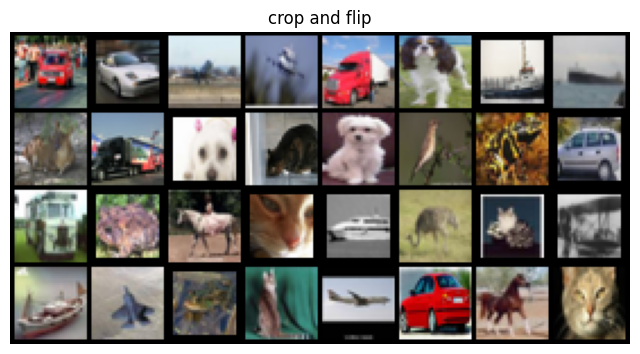

In [ ]:
train_loader, val_loader=get_dataset(32, cuda=False,crop=True, flip=0.5,normalize=False)
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("crop and flip")
plt.imshow(vutils.make_grid(real_batch[0], normalize=True).permute(1,2,0))
plt.show()

100%|██████████| 170498071/170498071 [00:02<00:00, 85124868.55it/s]


Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


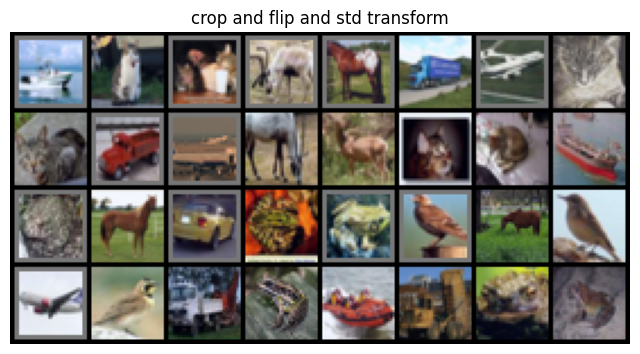

In [7]:
train_loader, val_loader=get_dataset(32, cuda=False,crop=True, flip=0.5,normalize='std')
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("crop and flip and std transform")
plt.imshow(vutils.make_grid(real_batch[0], normalize=True).permute(1,2,0))
plt.savefig('data increase visualization')
plt.show()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


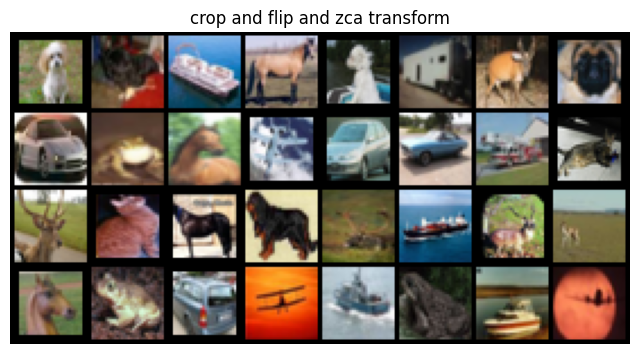

In [ ]:
train_loader, val_loader=get_dataset(32, cuda=False,crop=True, flip=0.5,normalize='zca')
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("crop and flip and zca transform")
plt.imshow(vutils.make_grid(real_batch[0], normalize=True).permute(1,2,0))
plt.show()

In [8]:
def epoch(data, model, criterion, optimizer=None, cuda=False, plot=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = utils.AverageMeter()
    avg_top1_acc = utils.AverageMeter()
    avg_top5_acc = utils.AverageMeter()
    avg_batch_time = utils.AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda:  # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = utils.accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer and plot:
            loss_plot.update(avg_loss.val)
        #print info
        # if i % PRINT_INTERVAL == 0:
        #     print('[{0:s} Batch {1:03d}/{2:03d}]\t'
        #           'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
        #           'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
        #           'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
        #           'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
        #            "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
        #            top1=avg_top1_acc, top5=avg_top5_acc))
        #     if optimizer and plot:
        #         loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss

In [9]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import PolynomialLR
from torch.optim.lr_scheduler import LinearLR
from torch.optim.lr_scheduler import CosineAnnealingLR

In [10]:
def main(batch_size=128, lr=0.1, epochs=5, cuda=False, save_name=None,scheduler_choice=False,crop=False, flip=False,normalize=False, batch_normalization=False, dropout=False,train=None, test=None):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    model = ConvNet( batch_normalization=batch_normalization, dropout=dropout)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

# 3.3 learning rate scheduler
    if scheduler_choice=='StepLR':
      scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    elif scheduler_choice=='MultiStep':
      scheduler = MultiStepLR(optimizer, milestones=[10, 20, 30], gamma=0.5)
    elif scheduler_choice=='ExponentialLR':
      scheduler = ExponentialLR(optimizer, gamma=0.99)
    elif scheduler_choice=='PolynomialLR':
      scheduler = PolynomialLR(optimizer)
    elif scheduler_choice=='LinearLR':
      scheduler = LinearLR(optimizer)
    elif scheduler_choice=='CosineAnnealingLR':
      scheduler = CosineAnnealingLR(optimizer)

    else:
      print('No LR modifying method, lr is constant=={}'.format(lr))

    if cuda:  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    if train is None:
      train, test = get_dataset(batch_size, cuda,crop=crop, flip=flip,normalize=normalize)

    # init plots
    plot = utils.AccLossPlot()
    global loss_plot
    train_plot = utils.TrainLossPlot()

    # We iterate on the epochs
    for i in tqdm(range(epochs)):
        # print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(
            test, model, criterion, cuda=cuda
        )
          # 3.3 learning rate scheduler
        if scheduler_choice:
          scheduler.step()
              # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)
    return plot,model

No LR modifying method, lr is constant==0.01
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 19s	Avg loss 2.0149	Avg Prec@1 25.17 %	Avg Prec@5 74.27 %



  7%|▋         | 1/15 [00:22<05:18, 22.72s/it]


===============> Total time 2s	Avg loss 1.6494	Avg Prec@1 39.09 %	Avg Prec@5 89.07 %


===============> Total time 19s	Avg loss 1.5534	Avg Prec@1 43.70 %	Avg Prec@5 90.52 %



 13%|█▎        | 2/15 [00:45<04:52, 22.46s/it]


===============> Total time 2s	Avg loss 1.4341	Avg Prec@1 48.04 %	Avg Prec@5 92.95 %


===============> Total time 18s	Avg loss 1.3431	Avg Prec@1 51.45 %	Avg Prec@5 93.64 %



 20%|██        | 3/15 [01:07<04:28, 22.36s/it]


===============> Total time 3s	Avg loss 1.2214	Avg Prec@1 56.47 %	Avg Prec@5 94.88 %


===============> Total time 18s	Avg loss 1.1849	Avg Prec@1 58.00 %	Avg Prec@5 95.31 %



 27%|██▋       | 4/15 [01:28<04:02, 22.02s/it]


===============> Total time 2s	Avg loss 1.1282	Avg Prec@1 59.82 %	Avg Prec@5 95.84 %


===============> Total time 20s	Avg loss 1.0531	Avg Prec@1 62.93 %	Avg Prec@5 96.46 %



 33%|███▎      | 5/15 [01:51<03:44, 22.45s/it]


===============> Total time 2s	Avg loss 1.0398	Avg Prec@1 63.57 %	Avg Prec@5 96.31 %


===============> Total time 19s	Avg loss 0.9425	Avg Prec@1 66.55 %	Avg Prec@5 97.26 %



 40%|████      | 6/15 [02:14<03:21, 22.34s/it]


===============> Total time 2s	Avg loss 1.0285	Avg Prec@1 63.79 %	Avg Prec@5 96.62 %


===============> Total time 19s	Avg loss 0.8405	Avg Prec@1 70.40 %	Avg Prec@5 97.87 %



 47%|████▋     | 7/15 [02:36<02:58, 22.33s/it]


===============> Total time 3s	Avg loss 0.9333	Avg Prec@1 67.54 %	Avg Prec@5 97.12 %


===============> Total time 18s	Avg loss 0.7486	Avg Prec@1 73.70 %	Avg Prec@5 98.36 %



 53%|█████▎    | 8/15 [02:58<02:36, 22.35s/it]


===============> Total time 3s	Avg loss 0.9394	Avg Prec@1 67.74 %	Avg Prec@5 97.27 %


===============> Total time 18s	Avg loss 0.6624	Avg Prec@1 76.73 %	Avg Prec@5 98.82 %



 60%|██████    | 9/15 [03:20<02:12, 22.15s/it]


===============> Total time 3s	Avg loss 0.9221	Avg Prec@1 68.46 %	Avg Prec@5 97.29 %


===============> Total time 19s	Avg loss 0.5788	Avg Prec@1 79.76 %	Avg Prec@5 99.14 %



 67%|██████▋   | 10/15 [03:42<01:50, 22.18s/it]


===============> Total time 2s	Avg loss 0.8543	Avg Prec@1 71.01 %	Avg Prec@5 97.68 %


===============> Total time 19s	Avg loss 0.4924	Avg Prec@1 82.67 %	Avg Prec@5 99.42 %



 73%|███████▎  | 11/15 [04:05<01:29, 22.25s/it]


===============> Total time 2s	Avg loss 0.9309	Avg Prec@1 70.03 %	Avg Prec@5 97.44 %


===============> Total time 19s	Avg loss 0.4167	Avg Prec@1 85.39 %	Avg Prec@5 99.58 %



 80%|████████  | 12/15 [04:27<01:06, 22.26s/it]


===============> Total time 2s	Avg loss 0.9351	Avg Prec@1 71.17 %	Avg Prec@5 97.50 %


===============> Total time 18s	Avg loss 0.3350	Avg Prec@1 88.39 %	Avg Prec@5 99.79 %



 87%|████████▋ | 13/15 [04:50<00:44, 22.38s/it]


===============> Total time 3s	Avg loss 1.0308	Avg Prec@1 70.31 %	Avg Prec@5 97.26 %


===============> Total time 18s	Avg loss 0.2675	Avg Prec@1 90.77 %	Avg Prec@5 99.89 %



 93%|█████████▎| 14/15 [05:11<00:22, 22.17s/it]


===============> Total time 2s	Avg loss 1.0500	Avg Prec@1 70.96 %	Avg Prec@5 97.20 %


===============> Total time 19s	Avg loss 0.2034	Avg Prec@1 92.85 %	Avg Prec@5 99.95 %



100%|██████████| 15/15 [05:34<00:00, 22.27s/it]


===============> Total time 2s	Avg loss 1.1161	Avg Prec@1 71.00 %	Avg Prec@5 97.42 %

No LR modifying method, lr is constant==0.01


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 13s	Avg loss 2.1459	Avg Prec@1 20.91 %	Avg Prec@5 67.80 %



  7%|▋         | 1/15 [00:15<03:37, 15.56s/it]


===============> Total time 2s	Avg loss 2.0068	Avg Prec@1 27.41 %	Avg Prec@5 78.07 %


===============> Total time 12s	Avg loss 1.7767	Avg Prec@1 36.07 %	Avg Prec@5 85.44 %



 13%|█▎        | 2/15 [00:30<03:17, 15.22s/it]


===============> Total time 2s	Avg loss 1.6759	Avg Prec@1 40.33 %	Avg Prec@5 87.24 %


===============> Total time 12s	Avg loss 1.5405	Avg Prec@1 44.61 %	Avg Prec@5 91.01 %



 20%|██        | 3/15 [00:45<03:01, 15.13s/it]


===============> Total time 2s	Avg loss 1.4713	Avg Prec@1 47.27 %	Avg Prec@5 91.82 %


===============> Total time 12s	Avg loss 1.4175	Avg Prec@1 49.39 %	Avg Prec@5 92.57 %



 27%|██▋       | 4/15 [01:00<02:46, 15.11s/it]


===============> Total time 2s	Avg loss 1.3538	Avg Prec@1 51.80 %	Avg Prec@5 93.82 %


===============> Total time 12s	Avg loss 1.3218	Avg Prec@1 53.00 %	Avg Prec@5 93.79 %



 33%|███▎      | 5/15 [01:16<02:34, 15.42s/it]


===============> Total time 2s	Avg loss 1.3133	Avg Prec@1 52.59 %	Avg Prec@5 93.91 %


===============> Total time 12s	Avg loss 1.2360	Avg Prec@1 56.21 %	Avg Prec@5 94.69 %



 40%|████      | 6/15 [01:31<02:17, 15.27s/it]


===============> Total time 2s	Avg loss 1.2118	Avg Prec@1 56.67 %	Avg Prec@5 94.98 %


===============> Total time 12s	Avg loss 1.1573	Avg Prec@1 59.12 %	Avg Prec@5 95.57 %



 47%|████▋     | 7/15 [01:46<02:01, 15.16s/it]


===============> Total time 2s	Avg loss 1.2828	Avg Prec@1 56.02 %	Avg Prec@5 93.99 %


===============> Total time 12s	Avg loss 1.0837	Avg Prec@1 61.94 %	Avg Prec@5 96.22 %



 53%|█████▎    | 8/15 [02:01<01:46, 15.15s/it]


===============> Total time 2s	Avg loss 1.1484	Avg Prec@1 59.77 %	Avg Prec@5 95.58 %


===============> Total time 12s	Avg loss 1.0122	Avg Prec@1 64.49 %	Avg Prec@5 96.71 %



 60%|██████    | 9/15 [02:16<01:31, 15.20s/it]


===============> Total time 2s	Avg loss 1.2039	Avg Prec@1 58.56 %	Avg Prec@5 94.63 %


===============> Total time 13s	Avg loss 0.9456	Avg Prec@1 66.96 %	Avg Prec@5 97.20 %



 67%|██████▋   | 10/15 [02:32<01:16, 15.38s/it]


===============> Total time 2s	Avg loss 1.1212	Avg Prec@1 61.37 %	Avg Prec@5 95.57 %


===============> Total time 12s	Avg loss 0.8804	Avg Prec@1 69.20 %	Avg Prec@5 97.59 %



 73%|███████▎  | 11/15 [02:47<01:01, 15.28s/it]


===============> Total time 2s	Avg loss 1.0271	Avg Prec@1 64.54 %	Avg Prec@5 96.55 %


===============> Total time 12s	Avg loss 0.8177	Avg Prec@1 71.56 %	Avg Prec@5 97.97 %



 80%|████████  | 12/15 [03:02<00:45, 15.22s/it]


===============> Total time 2s	Avg loss 1.0943	Avg Prec@1 61.96 %	Avg Prec@5 96.36 %


===============> Total time 12s	Avg loss 0.7582	Avg Prec@1 73.50 %	Avg Prec@5 98.32 %



 87%|████████▋ | 13/15 [03:17<00:30, 15.15s/it]


===============> Total time 2s	Avg loss 1.0187	Avg Prec@1 65.69 %	Avg Prec@5 96.77 %


===============> Total time 12s	Avg loss 0.6963	Avg Prec@1 75.56 %	Avg Prec@5 98.59 %



 93%|█████████▎| 14/15 [03:33<00:15, 15.34s/it]


===============> Total time 2s	Avg loss 1.0204	Avg Prec@1 66.15 %	Avg Prec@5 96.96 %


===============> Total time 12s	Avg loss 0.6395	Avg Prec@1 77.82 %	Avg Prec@5 98.83 %



100%|██████████| 15/15 [03:48<00:00, 15.26s/it]


===============> Total time 2s	Avg loss 0.9574	Avg Prec@1 67.77 %	Avg Prec@5 97.19 %

No LR modifying method, lr is constant==0.01


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 10s	Avg loss 2.2623	Avg Prec@1 14.50 %	Avg Prec@5 58.80 %



  7%|▋         | 1/15 [00:12<02:53, 12.36s/it]


===============> Total time 1s	Avg loss 2.1483	Avg Prec@1 21.31 %	Avg Prec@5 69.38 %


===============> Total time 10s	Avg loss 1.9969	Avg Prec@1 27.31 %	Avg Prec@5 78.04 %



 13%|█▎        | 2/15 [00:24<02:38, 12.18s/it]


===============> Total time 1s	Avg loss 1.9372	Avg Prec@1 29.78 %	Avg Prec@5 80.37 %


===============> Total time 10s	Avg loss 1.8371	Avg Prec@1 34.03 %	Avg Prec@5 83.82 %



 20%|██        | 3/15 [00:36<02:25, 12.10s/it]


===============> Total time 1s	Avg loss 1.7624	Avg Prec@1 37.56 %	Avg Prec@5 86.32 %


===============> Total time 10s	Avg loss 1.6902	Avg Prec@1 39.46 %	Avg Prec@5 87.60 %



 27%|██▋       | 4/15 [00:48<02:12, 12.05s/it]


===============> Total time 1s	Avg loss 1.6401	Avg Prec@1 40.97 %	Avg Prec@5 88.98 %


===============> Total time 10s	Avg loss 1.5731	Avg Prec@1 43.78 %	Avg Prec@5 90.10 %



 33%|███▎      | 5/15 [01:00<02:00, 12.05s/it]


===============> Total time 1s	Avg loss 1.5916	Avg Prec@1 44.06 %	Avg Prec@5 89.25 %


===============> Total time 10s	Avg loss 1.4933	Avg Prec@1 46.59 %	Avg Prec@5 91.38 %



 40%|████      | 6/15 [01:12<01:48, 12.06s/it]


===============> Total time 1s	Avg loss 1.5218	Avg Prec@1 45.48 %	Avg Prec@5 91.80 %


===============> Total time 10s	Avg loss 1.4267	Avg Prec@1 49.17 %	Avg Prec@5 92.51 %



 47%|████▋     | 7/15 [01:24<01:36, 12.08s/it]


===============> Total time 1s	Avg loss 1.4082	Avg Prec@1 49.47 %	Avg Prec@5 92.93 %


===============> Total time 10s	Avg loss 1.3674	Avg Prec@1 51.24 %	Avg Prec@5 93.16 %



 53%|█████▎    | 8/15 [01:36<01:24, 12.11s/it]


===============> Total time 1s	Avg loss 1.4286	Avg Prec@1 48.38 %	Avg Prec@5 92.99 %


===============> Total time 10s	Avg loss 1.3165	Avg Prec@1 53.32 %	Avg Prec@5 93.78 %



 60%|██████    | 9/15 [01:48<01:12, 12.11s/it]


===============> Total time 1s	Avg loss 1.4680	Avg Prec@1 46.28 %	Avg Prec@5 92.34 %


===============> Total time 9s	Avg loss 1.2662	Avg Prec@1 55.12 %	Avg Prec@5 94.59 %



 67%|██████▋   | 10/15 [02:00<01:00, 12.08s/it]


===============> Total time 2s	Avg loss 1.3139	Avg Prec@1 52.95 %	Avg Prec@5 94.11 %


===============> Total time 9s	Avg loss 1.2149	Avg Prec@1 57.09 %	Avg Prec@5 94.98 %



 73%|███████▎  | 11/15 [02:13<00:48, 12.08s/it]


===============> Total time 2s	Avg loss 1.4874	Avg Prec@1 47.00 %	Avg Prec@5 92.02 %


===============> Total time 9s	Avg loss 1.1676	Avg Prec@1 58.55 %	Avg Prec@5 95.47 %



 80%|████████  | 12/15 [02:25<00:36, 12.08s/it]


===============> Total time 2s	Avg loss 1.2523	Avg Prec@1 54.87 %	Avg Prec@5 95.15 %


===============> Total time 9s	Avg loss 1.1223	Avg Prec@1 60.50 %	Avg Prec@5 95.77 %



 87%|████████▋ | 13/15 [02:36<00:24, 12.02s/it]


===============> Total time 2s	Avg loss 1.2455	Avg Prec@1 56.35 %	Avg Prec@5 94.73 %


===============> Total time 9s	Avg loss 1.0773	Avg Prec@1 62.28 %	Avg Prec@5 96.31 %



 93%|█████████▎| 14/15 [02:48<00:11, 11.91s/it]


===============> Total time 2s	Avg loss 1.3390	Avg Prec@1 53.83 %	Avg Prec@5 93.32 %


===============> Total time 9s	Avg loss 1.0365	Avg Prec@1 63.63 %	Avg Prec@5 96.56 %



100%|██████████| 15/15 [03:00<00:00, 12.03s/it]


===============> Total time 1s	Avg loss 1.2623	Avg Prec@1 55.39 %	Avg Prec@5 95.33 %

No LR modifying method, lr is constant==0.01


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 8s	Avg loss 2.2983	Avg Prec@1 11.99 %	Avg Prec@5 54.47 %



  7%|▋         | 1/15 [00:10<02:30, 10.76s/it]


===============> Total time 2s	Avg loss 2.2899	Avg Prec@1 10.61 %	Avg Prec@5 54.45 %


===============> Total time 7s	Avg loss 2.2379	Avg Prec@1 15.05 %	Avg Prec@5 62.61 %



 13%|█▎        | 2/15 [00:20<02:11, 10.10s/it]


===============> Total time 1s	Avg loss 2.1579	Avg Prec@1 19.43 %	Avg Prec@5 70.78 %


===============> Total time 9s	Avg loss 2.0310	Avg Prec@1 25.65 %	Avg Prec@5 76.64 %



 20%|██        | 3/15 [00:31<02:04, 10.38s/it]


===============> Total time 1s	Avg loss 1.9636	Avg Prec@1 28.12 %	Avg Prec@5 79.71 %


===============> Total time 9s	Avg loss 1.9483	Avg Prec@1 29.57 %	Avg Prec@5 79.78 %



 27%|██▋       | 4/15 [00:41<01:55, 10.53s/it]


===============> Total time 1s	Avg loss 1.9165	Avg Prec@1 31.07 %	Avg Prec@5 80.89 %


===============> Total time 9s	Avg loss 1.8510	Avg Prec@1 33.61 %	Avg Prec@5 83.33 %



 33%|███▎      | 5/15 [00:52<01:45, 10.59s/it]


===============> Total time 1s	Avg loss 1.8262	Avg Prec@1 34.65 %	Avg Prec@5 84.02 %


===============> Total time 9s	Avg loss 1.7443	Avg Prec@1 37.56 %	Avg Prec@5 86.23 %



 40%|████      | 6/15 [01:03<01:35, 10.67s/it]


===============> Total time 1s	Avg loss 1.8053	Avg Prec@1 34.81 %	Avg Prec@5 85.51 %


===============> Total time 8s	Avg loss 1.6621	Avg Prec@1 40.42 %	Avg Prec@5 88.31 %



 47%|████▋     | 7/15 [01:14<01:25, 10.66s/it]


===============> Total time 2s	Avg loss 1.6554	Avg Prec@1 40.16 %	Avg Prec@5 88.72 %


===============> Total time 7s	Avg loss 1.5968	Avg Prec@1 42.86 %	Avg Prec@5 89.92 %



 53%|█████▎    | 8/15 [01:23<01:12, 10.37s/it]


===============> Total time 1s	Avg loss 1.6133	Avg Prec@1 42.26 %	Avg Prec@5 89.47 %


===============> Total time 8s	Avg loss 1.5444	Avg Prec@1 44.55 %	Avg Prec@5 90.77 %



 60%|██████    | 9/15 [01:34<01:02, 10.43s/it]


===============> Total time 1s	Avg loss 1.5652	Avg Prec@1 43.93 %	Avg Prec@5 90.10 %


===============> Total time 8s	Avg loss 1.5028	Avg Prec@1 46.26 %	Avg Prec@5 91.32 %



 67%|██████▋   | 10/15 [01:44<00:52, 10.49s/it]


===============> Total time 1s	Avg loss 1.7303	Avg Prec@1 39.59 %	Avg Prec@5 87.27 %


===============> Total time 9s	Avg loss 1.4670	Avg Prec@1 47.79 %	Avg Prec@5 91.98 %



 73%|███████▎  | 11/15 [01:55<00:42, 10.58s/it]


===============> Total time 1s	Avg loss 1.5947	Avg Prec@1 43.35 %	Avg Prec@5 90.65 %


===============> Total time 9s	Avg loss 1.4261	Avg Prec@1 49.19 %	Avg Prec@5 92.50 %



 80%|████████  | 12/15 [02:06<00:31, 10.60s/it]


===============> Total time 1s	Avg loss 1.4121	Avg Prec@1 49.20 %	Avg Prec@5 93.00 %


===============> Total time 8s	Avg loss 1.3965	Avg Prec@1 50.16 %	Avg Prec@5 92.89 %



 87%|████████▋ | 13/15 [02:17<00:21, 10.62s/it]


===============> Total time 2s	Avg loss 1.3752	Avg Prec@1 50.83 %	Avg Prec@5 93.18 %


===============> Total time 7s	Avg loss 1.3625	Avg Prec@1 51.67 %	Avg Prec@5 93.26 %



 93%|█████████▎| 14/15 [02:27<00:10, 10.46s/it]


===============> Total time 1s	Avg loss 1.3854	Avg Prec@1 50.38 %	Avg Prec@5 92.79 %


===============> Total time 8s	Avg loss 1.3320	Avg Prec@1 52.83 %	Avg Prec@5 93.59 %



100%|██████████| 15/15 [02:37<00:00, 10.49s/it]


===============> Total time 1s	Avg loss 1.3211	Avg Prec@1 53.09 %	Avg Prec@5 94.03 %

No LR modifying method, lr is constant==0.01


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 7s	Avg loss 2.3024	Avg Prec@1 10.83 %	Avg Prec@5 49.42 %



  7%|▋         | 1/15 [00:09<02:11,  9.37s/it]


===============> Total time 1s	Avg loss 2.3018	Avg Prec@1 14.25 %	Avg Prec@5 49.79 %


===============> Total time 8s	Avg loss 2.3013	Avg Prec@1 14.02 %	Avg Prec@5 50.57 %



 13%|█▎        | 2/15 [00:18<02:03,  9.48s/it]


===============> Total time 1s	Avg loss 2.3006	Avg Prec@1 12.99 %	Avg Prec@5 53.30 %


===============> Total time 7s	Avg loss 2.3000	Avg Prec@1 11.98 %	Avg Prec@5 54.53 %



 20%|██        | 3/15 [00:28<01:54,  9.51s/it]


===============> Total time 1s	Avg loss 2.2991	Avg Prec@1 11.24 %	Avg Prec@5 54.99 %


===============> Total time 7s	Avg loss 2.2983	Avg Prec@1 10.74 %	Avg Prec@5 56.98 %



 27%|██▋       | 4/15 [00:37<01:44,  9.46s/it]


===============> Total time 2s	Avg loss 2.2969	Avg Prec@1 10.73 %	Avg Prec@5 56.16 %


===============> Total time 6s	Avg loss 2.2957	Avg Prec@1 10.56 %	Avg Prec@5 55.00 %



 33%|███▎      | 5/15 [00:46<01:30,  9.09s/it]


===============> Total time 1s	Avg loss 2.2934	Avg Prec@1 10.53 %	Avg Prec@5 53.38 %


===============> Total time 7s	Avg loss 2.2913	Avg Prec@1 10.44 %	Avg Prec@5 53.31 %



 40%|████      | 6/15 [00:55<01:22,  9.20s/it]


===============> Total time 1s	Avg loss 2.2874	Avg Prec@1 10.62 %	Avg Prec@5 52.82 %


===============> Total time 7s	Avg loss 2.2832	Avg Prec@1 10.71 %	Avg Prec@5 53.66 %



 47%|████▋     | 7/15 [01:05<01:14,  9.26s/it]


===============> Total time 1s	Avg loss 2.2758	Avg Prec@1 11.15 %	Avg Prec@5 55.02 %


===============> Total time 6s	Avg loss 2.2663	Avg Prec@1 12.42 %	Avg Prec@5 57.72 %



 53%|█████▎    | 8/15 [01:13<01:03,  9.13s/it]


===============> Total time 1s	Avg loss 2.2499	Avg Prec@1 14.38 %	Avg Prec@5 61.43 %


===============> Total time 7s	Avg loss 2.2249	Avg Prec@1 16.89 %	Avg Prec@5 66.15 %



 60%|██████    | 9/15 [01:22<00:54,  9.08s/it]


===============> Total time 1s	Avg loss 2.1850	Avg Prec@1 20.81 %	Avg Prec@5 71.00 %


===============> Total time 7s	Avg loss 2.1317	Avg Prec@1 22.45 %	Avg Prec@5 74.02 %



 67%|██████▋   | 10/15 [01:32<00:46,  9.22s/it]


===============> Total time 1s	Avg loss 2.0643	Avg Prec@1 24.38 %	Avg Prec@5 76.13 %


===============> Total time 8s	Avg loss 2.0730	Avg Prec@1 24.02 %	Avg Prec@5 74.27 %



 73%|███████▎  | 11/15 [01:42<00:37,  9.35s/it]


===============> Total time 1s	Avg loss 2.0209	Avg Prec@1 26.40 %	Avg Prec@5 76.70 %


===============> Total time 6s	Avg loss 2.0315	Avg Prec@1 25.84 %	Avg Prec@5 76.29 %



 80%|████████  | 12/15 [01:50<00:27,  9.08s/it]


===============> Total time 1s	Avg loss 1.9943	Avg Prec@1 27.18 %	Avg Prec@5 78.40 %


===============> Total time 7s	Avg loss 2.0121	Avg Prec@1 26.44 %	Avg Prec@5 77.45 %



 87%|████████▋ | 13/15 [01:59<00:18,  9.16s/it]


===============> Total time 1s	Avg loss 1.9779	Avg Prec@1 27.41 %	Avg Prec@5 78.81 %


===============> Total time 7s	Avg loss 1.9931	Avg Prec@1 27.19 %	Avg Prec@5 78.25 %



 93%|█████████▎| 14/15 [02:09<00:09,  9.27s/it]


===============> Total time 1s	Avg loss 1.9632	Avg Prec@1 28.86 %	Avg Prec@5 79.55 %


===============> Total time 7s	Avg loss 1.9742	Avg Prec@1 28.10 %	Avg Prec@5 79.03 %



100%|██████████| 15/15 [02:18<00:00,  9.26s/it]


===============> Total time 1s	Avg loss 1.9796	Avg Prec@1 27.71 %	Avg Prec@5 79.17 %



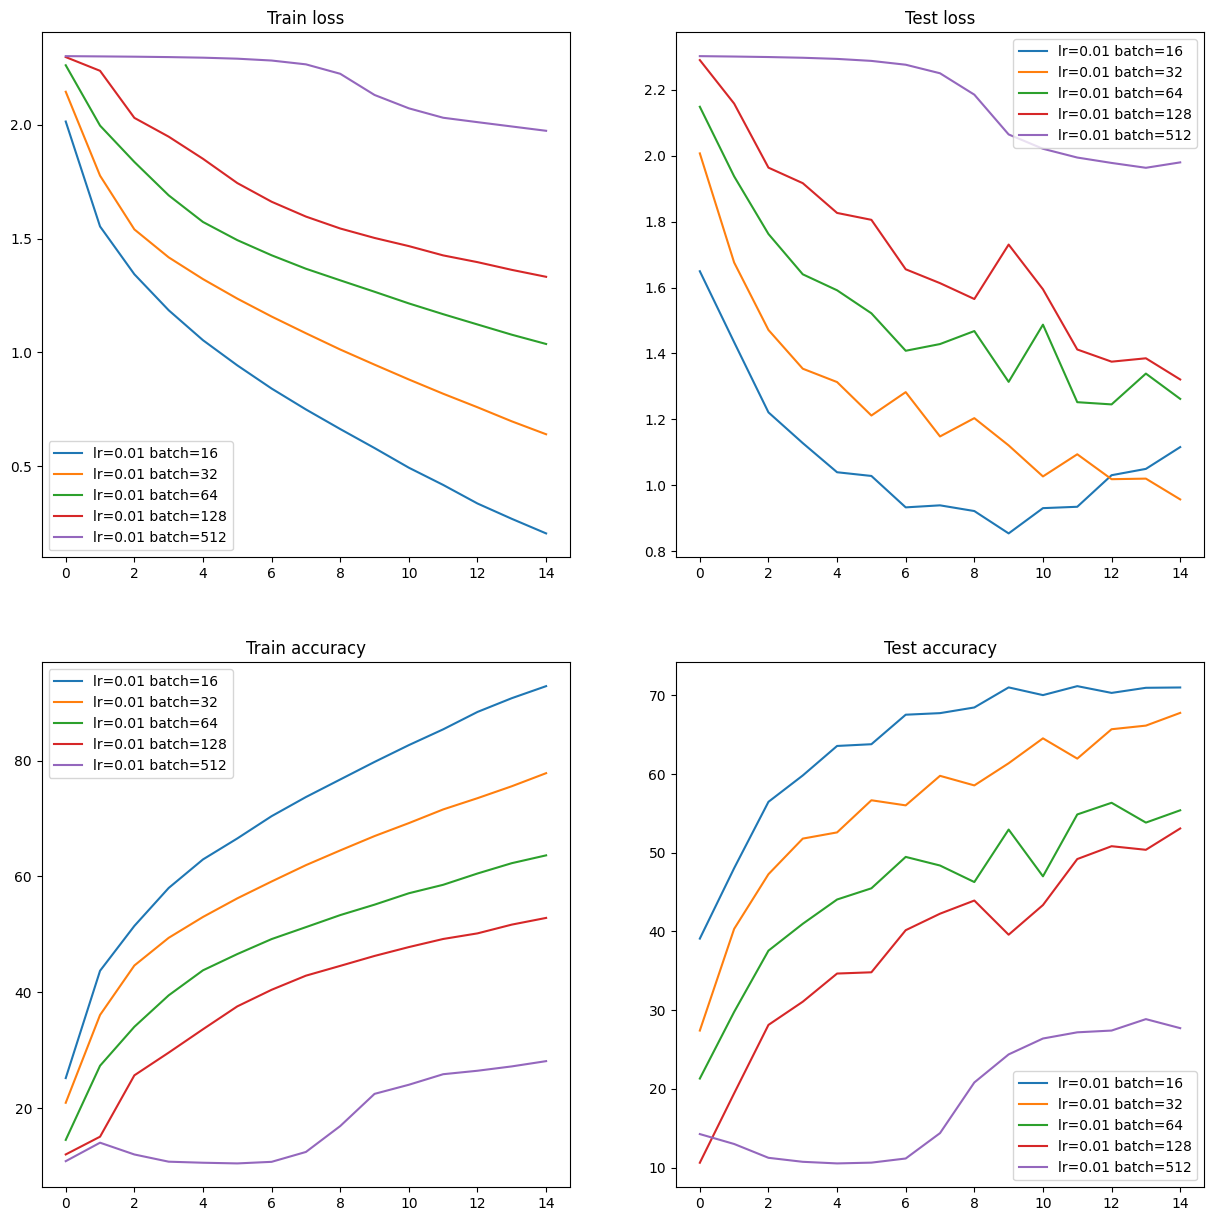

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
from tqdm import tqdm
cuda = torch.cuda.is_available()
loss_train_batch = []
loss_test_batch = []
acc_train_batch = []
acc_test_batch = []
fig1, axes1 = plt.subplots(2, 2, figsize=(15, 15))
axes1[0,0].set_title('Train loss')
axes1[0,1].set_title('Test loss')
axes1[1,0].set_title('Train accuracy')
axes1[1,1].set_title('Test accuracy')
for batch in [16,32,64,128,512]:
  plot,_=main(batch, 0.01, epochs=15, cuda=cuda,save_name="batch128_lr0.1")
  loss_train_batch.append(plot.loss_train)
  loss_test_batch.append(plot.loss_test)
  acc_train_batch.append(plot.acc_train)
  acc_test_batch.append(plot.acc_test)
  axes1[0,0].plot(plot.loss_train,label="lr=0.01 batch={}".format(batch))
  axes1[0,1].plot(plot.loss_test,label="lr=0.01 batch={}".format(batch))
  axes1[1,0].plot(plot.acc_train,label="lr=0.01 batch={}".format(batch))
  axes1[1,1].plot(plot.acc_test,label="lr=0.01 batch={}".format(batch))

axes1[0,0].legend()
axes1[1,0].legend()
axes1[0,1].legend()
axes1[1,1].legend()
fig1.savefig('batch choices')

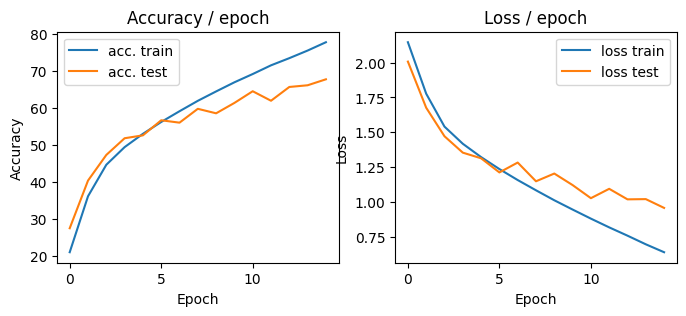

In [23]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(np.array(acc_train_batch[1]), label="acc. train")
plt.plot(np.array(acc_test_batch[1]), label="acc. test")
plt.title("Accuracy / epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.array(loss_train_batch[1]), label="loss train")
plt.plot(np.array(loss_test_batch[1]), label="loss test")
plt.title("Loss / epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('base performance')
plt.show()

In [24]:
acc_test_batch[1][-1]

67.77156549520767

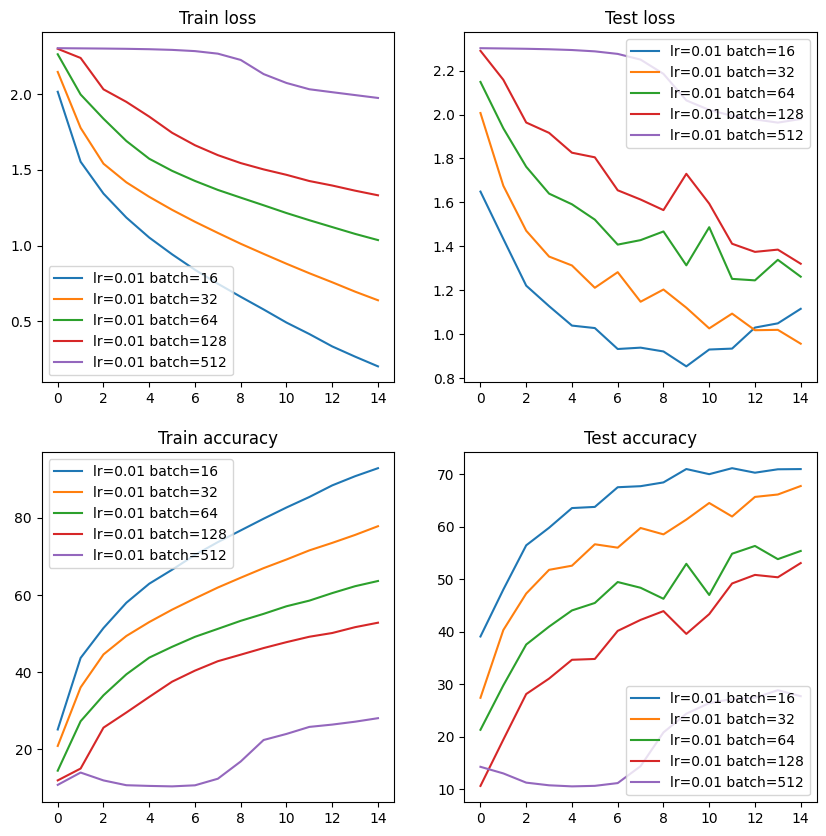

In [22]:

fig1, axes1 = plt.subplots(2, 2, figsize=(10, 10))
axes1[0,0].set_title('Train loss')
axes1[0,1].set_title('Test loss')
axes1[1,0].set_title('Train accuracy')
axes1[1,1].set_title('Test accuracy')
for i,batch in enumerate([16,32,64,128,512]):
  axes1[0,0].plot(loss_train_batch[i],label="lr=0.01 batch={}".format(batch))
  axes1[0,1].plot(loss_test_batch[i],label="lr=0.01 batch={}".format(batch))
  axes1[1,0].plot(acc_train_batch[i],label="lr=0.01 batch={}".format(batch))
  axes1[1,1].plot(acc_test_batch[i],label="lr=0.01 batch={}".format(batch))

axes1[0,0].legend()
axes1[1,0].legend()
axes1[0,1].legend()
axes1[1,1].legend()
fig1.savefig('batch choices')

In [ ]:
from pyparsing.helpers import original_text_for
import numpy as np

np.save("original_loss_train_batch .npy",loss_train_batch )
np.save("original_loss_test_batch .npy",loss_test_batch )
np.save("original_acc_train_batch .npy",acc_train_batch )
np.save("original_acc_test_batch .npy",acc_test_batch )

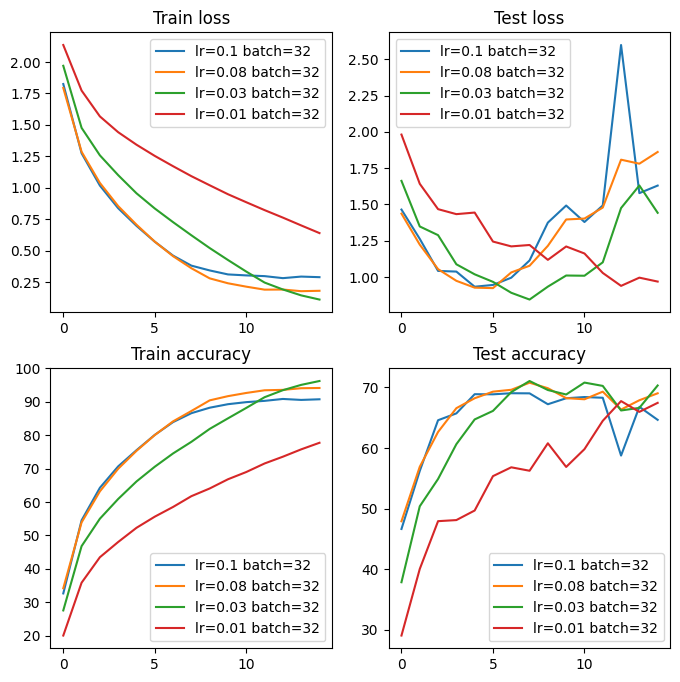

In [ ]:
loss_train_lr = []
loss_test_lr = []
acc_train_lr = []
acc_test_lr = []
fig1, axes1 = plt.subplots(2, 2, figsize=(10, 10))
axes1[0,0].set_title('Train loss')
axes1[0,1].set_title('Test loss')
axes1[1,0].set_title('Train accuracy')
axes1[1,1].set_title('Test accuracy')
for lr in [0.1,0.08,0.03,0.01]:
  plot,_=main(32, lr, epochs=15, cuda=cuda,save_name="batch128_lr0.1")
  loss_train_lr.append(plot.loss_train)
  loss_test_lr.append(plot.loss_test)
  acc_train_lr.append(plot.acc_train)
  acc_test_lr.append(plot.acc_test)
  axes1[0,0].plot(plot.loss_train,label="lr={} batch=32".format(lr))
  axes1[0,1].plot(plot.loss_test,label="lr={} batch=32".format(lr))
  axes1[1,0].plot(plot.acc_train,label="lr={} batch=32".format(lr))
  axes1[1,1].plot(plot.acc_train,label="lr={} batch=32".format(lr))

axes1[0,0].legend()
axes1[1,0].legend()
axes1[0,1].legend()
axes1[1,1].legend()
fig1.savefig('lr choices')

In [ ]:
np.save("original_loss_train_lr .npy",loss_train_lr )
np.save("original_loss_test_lr .npy",loss_test_lr )
np.save("original_acc_train_lr .npy",acc_train_lr)
np.save("original_acc_test_lr .npy",acc_test_lr)

No LR modifying method, lr is constant==0.01
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 12s	Avg loss 2.1514	Avg Prec@1 19.21 %	Avg Prec@5 66.60 %



  7%|▋         | 1/15 [00:15<03:32, 15.20s/it]


===============> Total time 2s	Avg loss 1.9160	Avg Prec@1 30.39 %	Avg Prec@5 82.14 %


===============> Total time 13s	Avg loss 1.7495	Avg Prec@1 36.79 %	Avg Prec@5 86.24 %



 13%|█▎        | 2/15 [00:30<03:21, 15.48s/it]


===============> Total time 2s	Avg loss 1.7159	Avg Prec@1 39.24 %	Avg Prec@5 86.74 %


===============> Total time 13s	Avg loss 1.5353	Avg Prec@1 44.63 %	Avg Prec@5 91.05 %



 20%|██        | 3/15 [00:48<03:15, 16.29s/it]


===============> Total time 3s	Avg loss 1.4843	Avg Prec@1 46.70 %	Avg Prec@5 91.56 %


===============> Total time 19s	Avg loss 1.4078	Avg Prec@1 49.45 %	Avg Prec@5 92.93 %



 27%|██▋       | 4/15 [01:10<03:24, 18.60s/it]


===============> Total time 2s	Avg loss 1.3340	Avg Prec@1 52.34 %	Avg Prec@5 93.59 %


===============> Total time 13s	Avg loss 1.3059	Avg Prec@1 53.25 %	Avg Prec@5 94.14 %



 33%|███▎      | 5/15 [01:26<02:57, 17.74s/it]


===============> Total time 2s	Avg loss 1.2766	Avg Prec@1 54.51 %	Avg Prec@5 94.32 %


===============> Total time 13s	Avg loss 1.2164	Avg Prec@1 56.77 %	Avg Prec@5 95.05 %



 40%|████      | 6/15 [01:41<02:32, 16.93s/it]


===============> Total time 2s	Avg loss 1.2232	Avg Prec@1 56.57 %	Avg Prec@5 95.21 %


===============> Total time 12s	Avg loss 1.1348	Avg Prec@1 59.98 %	Avg Prec@5 95.75 %



 47%|████▋     | 7/15 [01:56<02:10, 16.34s/it]


===============> Total time 2s	Avg loss 1.1237	Avg Prec@1 60.68 %	Avg Prec@5 96.19 %


===============> Total time 13s	Avg loss 1.0598	Avg Prec@1 62.63 %	Avg Prec@5 96.53 %



 53%|█████▎    | 8/15 [02:12<01:52, 16.01s/it]


===============> Total time 2s	Avg loss 1.1505	Avg Prec@1 59.02 %	Avg Prec@5 95.58 %


===============> Total time 14s	Avg loss 0.9897	Avg Prec@1 65.45 %	Avg Prec@5 96.97 %



 60%|██████    | 9/15 [02:29<01:37, 16.27s/it]


===============> Total time 2s	Avg loss 1.0631	Avg Prec@1 62.51 %	Avg Prec@5 96.52 %


===============> Total time 13s	Avg loss 0.9226	Avg Prec@1 67.73 %	Avg Prec@5 97.38 %



 67%|██████▋   | 10/15 [02:44<01:20, 16.04s/it]


===============> Total time 2s	Avg loss 1.0683	Avg Prec@1 62.35 %	Avg Prec@5 96.91 %


===============> Total time 14s	Avg loss 0.8603	Avg Prec@1 69.86 %	Avg Prec@5 97.72 %



 73%|███████▎  | 11/15 [03:01<01:05, 16.29s/it]


===============> Total time 2s	Avg loss 1.0267	Avg Prec@1 64.32 %	Avg Prec@5 97.13 %


===============> Total time 13s	Avg loss 0.7987	Avg Prec@1 72.37 %	Avg Prec@5 98.10 %



 80%|████████  | 12/15 [03:17<00:48, 16.30s/it]


===============> Total time 2s	Avg loss 0.9800	Avg Prec@1 66.07 %	Avg Prec@5 97.06 %


===============> Total time 13s	Avg loss 0.7399	Avg Prec@1 74.23 %	Avg Prec@5 98.34 %



 87%|████████▋ | 13/15 [03:33<00:32, 16.01s/it]


===============> Total time 2s	Avg loss 0.9467	Avg Prec@1 67.50 %	Avg Prec@5 97.28 %


===============> Total time 17s	Avg loss 0.6850	Avg Prec@1 76.28 %	Avg Prec@5 98.64 %



 93%|█████████▎| 14/15 [03:55<00:17, 17.78s/it]


===============> Total time 4s	Avg loss 0.9061	Avg Prec@1 69.06 %	Avg Prec@5 97.69 %


===============> Total time 19s	Avg loss 0.6273	Avg Prec@1 78.07 %	Avg Prec@5 98.91 %



100%|██████████| 15/15 [04:16<00:00, 17.12s/it]


===============> Total time 2s	Avg loss 0.9371	Avg Prec@1 68.14 %	Avg Prec@5 97.43 %

No LR modifying method, lr is constant==0.02


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 9s	Avg loss 2.2501	Avg Prec@1 14.89 %	Avg Prec@5 60.68 %



  7%|▋         | 1/15 [00:12<02:51, 12.28s/it]


===============> Total time 2s	Avg loss 2.0260	Avg Prec@1 24.67 %	Avg Prec@5 75.93 %


===============> Total time 9s	Avg loss 1.9074	Avg Prec@1 30.60 %	Avg Prec@5 81.64 %



 13%|█▎        | 2/15 [00:24<02:41, 12.42s/it]


===============> Total time 2s	Avg loss 1.8154	Avg Prec@1 33.94 %	Avg Prec@5 85.37 %


===============> Total time 9s	Avg loss 1.6507	Avg Prec@1 40.12 %	Avg Prec@5 88.82 %



 20%|██        | 3/15 [00:37<02:28, 12.38s/it]


===============> Total time 2s	Avg loss 1.7661	Avg Prec@1 35.52 %	Avg Prec@5 87.44 %


===============> Total time 12s	Avg loss 1.4973	Avg Prec@1 45.98 %	Avg Prec@5 91.56 %



 27%|██▋       | 4/15 [00:51<02:26, 13.30s/it]


===============> Total time 2s	Avg loss 1.5738	Avg Prec@1 41.35 %	Avg Prec@5 92.11 %


===============> Total time 9s	Avg loss 1.3830	Avg Prec@1 50.60 %	Avg Prec@5 93.13 %



 33%|███▎      | 5/15 [01:04<02:09, 12.92s/it]


===============> Total time 2s	Avg loss 1.4366	Avg Prec@1 48.87 %	Avg Prec@5 93.07 %


===============> Total time 10s	Avg loss 1.2900	Avg Prec@1 54.15 %	Avg Prec@5 94.29 %



 40%|████      | 6/15 [01:17<01:56, 12.92s/it]


===============> Total time 2s	Avg loss 1.3226	Avg Prec@1 51.83 %	Avg Prec@5 94.17 %


===============> Total time 10s	Avg loss 1.2016	Avg Prec@1 57.66 %	Avg Prec@5 95.17 %



 47%|████▋     | 7/15 [01:29<01:42, 12.78s/it]


===============> Total time 1s	Avg loss 1.3742	Avg Prec@1 51.43 %	Avg Prec@5 93.50 %


===============> Total time 11s	Avg loss 1.1224	Avg Prec@1 60.46 %	Avg Prec@5 95.86 %



 53%|█████▎    | 8/15 [01:42<01:29, 12.83s/it]


===============> Total time 1s	Avg loss 1.1276	Avg Prec@1 60.22 %	Avg Prec@5 96.07 %


===============> Total time 10s	Avg loss 1.0500	Avg Prec@1 63.17 %	Avg Prec@5 96.48 %



 60%|██████    | 9/15 [01:54<01:16, 12.70s/it]


===============> Total time 1s	Avg loss 1.1682	Avg Prec@1 59.22 %	Avg Prec@5 95.90 %


===============> Total time 10s	Avg loss 0.9785	Avg Prec@1 65.86 %	Avg Prec@5 96.88 %



 67%|██████▋   | 10/15 [02:07<01:03, 12.62s/it]


===============> Total time 1s	Avg loss 1.3232	Avg Prec@1 54.90 %	Avg Prec@5 95.22 %


===============> Total time 9s	Avg loss 0.9119	Avg Prec@1 68.39 %	Avg Prec@5 97.38 %



 73%|███████▎  | 11/15 [02:19<00:50, 12.54s/it]


===============> Total time 2s	Avg loss 1.2345	Avg Prec@1 57.85 %	Avg Prec@5 95.39 %


===============> Total time 9s	Avg loss 0.8480	Avg Prec@1 70.33 %	Avg Prec@5 97.79 %



 80%|████████  | 12/15 [02:31<00:37, 12.47s/it]


===============> Total time 2s	Avg loss 1.0097	Avg Prec@1 65.44 %	Avg Prec@5 96.76 %


===============> Total time 9s	Avg loss 0.7866	Avg Prec@1 72.71 %	Avg Prec@5 98.15 %



 87%|████████▋ | 13/15 [02:44<00:24, 12.42s/it]


===============> Total time 2s	Avg loss 1.1483	Avg Prec@1 60.55 %	Avg Prec@5 96.53 %


===============> Total time 10s	Avg loss 0.7286	Avg Prec@1 74.48 %	Avg Prec@5 98.46 %



 93%|█████████▎| 14/15 [02:57<00:12, 12.62s/it]


===============> Total time 2s	Avg loss 1.1706	Avg Prec@1 60.98 %	Avg Prec@5 95.91 %


===============> Total time 9s	Avg loss 0.6695	Avg Prec@1 76.61 %	Avg Prec@5 98.71 %



100%|██████████| 15/15 [03:09<00:00, 12.65s/it]


===============> Total time 2s	Avg loss 1.0042	Avg Prec@1 66.32 %	Avg Prec@5 97.00 %

No LR modifying method, lr is constant==0.04


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 9s	Avg loss 2.2729	Avg Prec@1 13.76 %	Avg Prec@5 59.19 %



  7%|▋         | 1/15 [00:10<02:31, 10.83s/it]


===============> Total time 1s	Avg loss 2.0708	Avg Prec@1 23.70 %	Avg Prec@5 76.53 %


===============> Total time 8s	Avg loss 1.9690	Avg Prec@1 28.59 %	Avg Prec@5 79.33 %



 13%|█▎        | 2/15 [00:21<02:21, 10.89s/it]


===============> Total time 1s	Avg loss 1.7902	Avg Prec@1 36.43 %	Avg Prec@5 85.25 %


===============> Total time 8s	Avg loss 1.7153	Avg Prec@1 38.31 %	Avg Prec@5 87.18 %



 20%|██        | 3/15 [00:32<02:09, 10.82s/it]


===============> Total time 2s	Avg loss 1.5362	Avg Prec@1 44.50 %	Avg Prec@5 91.07 %


===============> Total time 8s	Avg loss 1.5431	Avg Prec@1 44.82 %	Avg Prec@5 90.64 %



 27%|██▋       | 4/15 [00:42<01:56, 10.60s/it]


===============> Total time 1s	Avg loss 1.4476	Avg Prec@1 47.70 %	Avg Prec@5 92.38 %


===============> Total time 10s	Avg loss 1.4235	Avg Prec@1 49.13 %	Avg Prec@5 92.51 %



 33%|███▎      | 5/15 [00:54<01:50, 11.05s/it]


===============> Total time 1s	Avg loss 1.4111	Avg Prec@1 48.74 %	Avg Prec@5 92.83 %


===============> Total time 9s	Avg loss 1.3263	Avg Prec@1 52.90 %	Avg Prec@5 93.72 %



 40%|████      | 6/15 [01:05<01:39, 11.05s/it]


===============> Total time 1s	Avg loss 1.3262	Avg Prec@1 52.97 %	Avg Prec@5 93.44 %


===============> Total time 9s	Avg loss 1.2433	Avg Prec@1 55.85 %	Avg Prec@5 94.69 %



 47%|████▋     | 7/15 [01:16<01:28, 11.06s/it]


===============> Total time 1s	Avg loss 1.3209	Avg Prec@1 52.72 %	Avg Prec@5 94.55 %


===============> Total time 9s	Avg loss 1.1593	Avg Prec@1 59.07 %	Avg Prec@5 95.52 %



 53%|█████▎    | 8/15 [01:28<01:18, 11.21s/it]


===============> Total time 1s	Avg loss 1.1999	Avg Prec@1 56.92 %	Avg Prec@5 95.12 %


===============> Total time 12s	Avg loss 1.0869	Avg Prec@1 61.63 %	Avg Prec@5 96.22 %



 60%|██████    | 9/15 [01:42<01:13, 12.22s/it]


===============> Total time 1s	Avg loss 1.1606	Avg Prec@1 58.38 %	Avg Prec@5 95.54 %


===============> Total time 9s	Avg loss 1.0156	Avg Prec@1 64.45 %	Avg Prec@5 96.68 %



 67%|██████▋   | 10/15 [01:53<00:59, 11.84s/it]


===============> Total time 1s	Avg loss 1.0887	Avg Prec@1 61.58 %	Avg Prec@5 96.12 %


===============> Total time 9s	Avg loss 0.9483	Avg Prec@1 66.79 %	Avg Prec@5 97.17 %



 73%|███████▎  | 11/15 [02:04<00:46, 11.65s/it]


===============> Total time 1s	Avg loss 1.0478	Avg Prec@1 63.05 %	Avg Prec@5 96.39 %


===============> Total time 10s	Avg loss 0.8847	Avg Prec@1 69.01 %	Avg Prec@5 97.55 %



 80%|████████  | 12/15 [02:17<00:35, 11.89s/it]


===============> Total time 1s	Avg loss 1.0663	Avg Prec@1 62.68 %	Avg Prec@5 96.46 %


===============> Total time 8s	Avg loss 0.8253	Avg Prec@1 71.20 %	Avg Prec@5 97.92 %



 87%|████████▋ | 13/15 [02:28<00:23, 11.55s/it]


===============> Total time 2s	Avg loss 0.9478	Avg Prec@1 66.73 %	Avg Prec@5 97.11 %


===============> Total time 8s	Avg loss 0.7637	Avg Prec@1 73.25 %	Avg Prec@5 98.20 %



 93%|█████████▎| 14/15 [02:38<00:11, 11.17s/it]


===============> Total time 1s	Avg loss 0.9746	Avg Prec@1 66.26 %	Avg Prec@5 96.58 %


===============> Total time 8s	Avg loss 0.7071	Avg Prec@1 75.47 %	Avg Prec@5 98.54 %



100%|██████████| 15/15 [02:48<00:00, 11.26s/it]


===============> Total time 1s	Avg loss 1.0516	Avg Prec@1 63.57 %	Avg Prec@5 96.81 %

No LR modifying method, lr is constant==0.08


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 7s	Avg loss 2.2136	Avg Prec@1 17.35 %	Avg Prec@5 64.52 %



  7%|▋         | 1/15 [00:09<02:12,  9.44s/it]


===============> Total time 1s	Avg loss 2.0636	Avg Prec@1 24.01 %	Avg Prec@5 76.47 %


===============> Total time 8s	Avg loss 1.9887	Avg Prec@1 28.81 %	Avg Prec@5 79.04 %



 13%|█▎        | 2/15 [00:19<02:07,  9.83s/it]


===============> Total time 1s	Avg loss 1.9173	Avg Prec@1 30.69 %	Avg Prec@5 84.10 %


===============> Total time 8s	Avg loss 1.7562	Avg Prec@1 37.20 %	Avg Prec@5 86.21 %



 20%|██        | 3/15 [00:29<01:59,  9.97s/it]


===============> Total time 1s	Avg loss 1.6704	Avg Prec@1 37.93 %	Avg Prec@5 89.60 %


===============> Total time 8s	Avg loss 1.5890	Avg Prec@1 43.15 %	Avg Prec@5 90.03 %



 27%|██▋       | 4/15 [00:39<01:50, 10.03s/it]


===============> Total time 1s	Avg loss 1.5499	Avg Prec@1 44.01 %	Avg Prec@5 90.44 %


===============> Total time 7s	Avg loss 1.4711	Avg Prec@1 47.90 %	Avg Prec@5 91.73 %



 33%|███▎      | 5/15 [00:49<01:40, 10.03s/it]


===============> Total time 2s	Avg loss 1.4601	Avg Prec@1 46.25 %	Avg Prec@5 91.94 %


===============> Total time 7s	Avg loss 1.3830	Avg Prec@1 50.84 %	Avg Prec@5 93.00 %



 40%|████      | 6/15 [00:59<01:27,  9.75s/it]


===============> Total time 1s	Avg loss 1.3861	Avg Prec@1 49.85 %	Avg Prec@5 93.28 %


===============> Total time 8s	Avg loss 1.3008	Avg Prec@1 53.96 %	Avg Prec@5 93.99 %



 47%|████▋     | 7/15 [01:09<01:19,  9.88s/it]


===============> Total time 1s	Avg loss 1.3816	Avg Prec@1 50.76 %	Avg Prec@5 93.25 %


===============> Total time 8s	Avg loss 1.2320	Avg Prec@1 56.56 %	Avg Prec@5 94.67 %



 53%|█████▎    | 8/15 [01:19<01:09,  9.96s/it]


===============> Total time 1s	Avg loss 1.2721	Avg Prec@1 54.18 %	Avg Prec@5 94.54 %


===============> Total time 8s	Avg loss 1.1707	Avg Prec@1 58.67 %	Avg Prec@5 95.30 %



 60%|██████    | 9/15 [01:29<01:00, 10.03s/it]


===============> Total time 1s	Avg loss 1.2933	Avg Prec@1 53.96 %	Avg Prec@5 93.88 %


===============> Total time 7s	Avg loss 1.1029	Avg Prec@1 61.24 %	Avg Prec@5 95.96 %



 67%|██████▋   | 10/15 [01:38<00:49,  9.86s/it]


===============> Total time 1s	Avg loss 1.1975	Avg Prec@1 57.69 %	Avg Prec@5 95.06 %


===============> Total time 8s	Avg loss 1.0337	Avg Prec@1 63.66 %	Avg Prec@5 96.44 %



 73%|███████▎  | 11/15 [01:48<00:39,  9.86s/it]


===============> Total time 1s	Avg loss 1.1723	Avg Prec@1 59.05 %	Avg Prec@5 95.77 %


===============> Total time 8s	Avg loss 0.9793	Avg Prec@1 65.48 %	Avg Prec@5 96.86 %



 80%|████████  | 12/15 [01:59<00:29,  9.99s/it]


===============> Total time 1s	Avg loss 1.2906	Avg Prec@1 54.02 %	Avg Prec@5 95.25 %


===============> Total time 8s	Avg loss 0.9189	Avg Prec@1 67.88 %	Avg Prec@5 97.29 %



 87%|████████▋ | 13/15 [02:09<00:20, 10.08s/it]


===============> Total time 1s	Avg loss 1.0816	Avg Prec@1 61.92 %	Avg Prec@5 96.08 %


===============> Total time 8s	Avg loss 0.8532	Avg Prec@1 70.18 %	Avg Prec@5 97.74 %



 93%|█████████▎| 14/15 [02:19<00:10, 10.17s/it]


===============> Total time 1s	Avg loss 1.1563	Avg Prec@1 61.62 %	Avg Prec@5 95.45 %


===============> Total time 7s	Avg loss 0.7990	Avg Prec@1 72.14 %	Avg Prec@5 98.09 %



100%|██████████| 15/15 [02:28<00:00,  9.93s/it]


===============> Total time 1s	Avg loss 1.1427	Avg Prec@1 60.59 %	Avg Prec@5 95.87 %



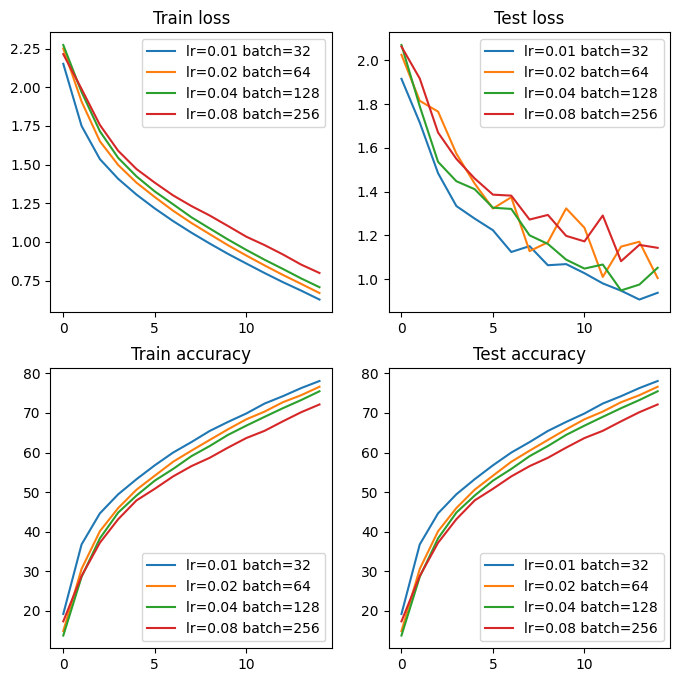

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [25]:
loss_train_lb = []
loss_test_lb = []
acc_train_lb = []
acc_test_lb = []
fig1, axes1 = plt.subplots(2, 2, figsize=(8, 8))
axes1[0,0].set_title('Train loss')
axes1[0,1].set_title('Test loss')
axes1[1,0].set_title('Train accuracy')
axes1[1,1].set_title('Test accuracy')
for batch,lr in [[32,0.01],[64,0.02],[128,0.04],[256,0.08]]:
  plot,_=main(batch,lr, epochs=15, cuda=cuda,save_name="batch128_lr0.1")
  loss_train_lb.append(plot.loss_train)
  loss_test_lb.append(plot.loss_test)
  acc_train_lb.append(plot.acc_train)
  acc_test_lb.append(plot.acc_test)
  axes1[0,0].plot(plot.loss_train,label="lr={} batch={}".format(lr,batch))
  axes1[0,1].plot(plot.loss_test,label="lr={} batch={}".format(lr,batch))
  axes1[1,0].plot(plot.acc_train,label="lr={} batch={}".format(lr,batch))
  axes1[1,1].plot(plot.acc_test,label="lr={} batch={}".format(lr,batch))
axes1[0,0].legend()
axes1[1,0].legend()
axes1[0,1].legend()
axes1[1,1].legend()
fig1.savefig('lr_batch choices')

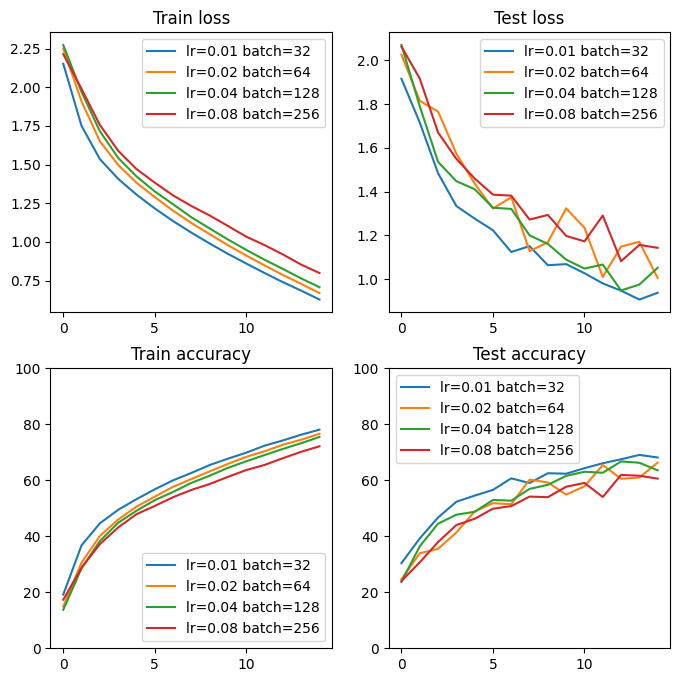

In [28]:
fig1, axes1 = plt.subplots(2, 2, figsize=(8, 8))
axes1[0,0].set_title('Train loss')
axes1[0,1].set_title('Test loss')
axes1[1,0].set_title('Train accuracy')
axes1[1,1].set_title('Test accuracy')
for i,[batch,lr] in enumerate([[32,0.01],[64,0.02],[128,0.04],[256,0.08]]):

  axes1[0,0].plot(loss_train_lb[i],label="lr={} batch={}".format(lr,batch))
  axes1[0,1].plot( loss_test_lb[i],label="lr={} batch={}".format(lr,batch))
  axes1[1,0].plot(acc_train_lb[i],label="lr={} batch={}".format(lr,batch))
  axes1[1,1].plot(  acc_test_lb[i],label="lr={} batch={}".format(lr,batch))
axes1[0,0].legend()
axes1[1,0].legend()
axes1[0,1].legend()
axes1[1,1].legend()
axes1[1,0].set_ylim(0,100)
axes1[1,1].set_ylim(0,100)
fig1.savefig('lr_batch choices')

In [ ]:
np.save("original_loss_train_lb .npy",loss_train_lb )
np.save("original_loss_test_lb.npy",loss_test_lb )
np.save("original_acc_train_lb .npy",acc_train_lb)
np.save("original_acc_test_lb.npy",acc_test_lb)

In [29]:
plot_base,model_base=main(32, lr, epochs=15, cuda=cuda,save_name="batch128_lr0.1")

# from sklearn.metrics import confusion_matrix
# Yhat_test = model_base(real_x)
# Yhat_test = Yhat_test.argmax(dim=1).numpy()
# Ytest = data.Ytest.argmax(dim=1).numpy()
# cm = confusion_matrix(Ytest, Yhat_test)
# cm = cm / cm.sum(axis=1)[:, np.newaxis]
# plt.xticks(range(10))
# plt.yticks(range(10))
# plt.imshow(cm,cmap=plt.cm.Blues)
# plt.title('Confusion matrix')
# plt.colorbar()
# plt.savefig('confusion_matrix_MNIST.png')


No LR modifying method, lr is constant==0.08
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 13s	Avg loss 1.8701	Avg Prec@1 30.97 %	Avg Prec@5 79.71 %



  7%|▋         | 1/15 [00:15<03:37, 15.57s/it]


===============> Total time 2s	Avg loss 1.4958	Avg Prec@1 45.90 %	Avg Prec@5 92.06 %


===============> Total time 13s	Avg loss 1.3179	Avg Prec@1 52.76 %	Avg Prec@5 93.97 %



 13%|█▎        | 2/15 [00:31<03:27, 15.94s/it]


===============> Total time 2s	Avg loss 1.3061	Avg Prec@1 53.03 %	Avg Prec@5 94.03 %


===============> Total time 13s	Avg loss 1.0733	Avg Prec@1 62.06 %	Avg Prec@5 96.31 %



 20%|██        | 3/15 [00:48<03:14, 16.24s/it]


===============> Total time 3s	Avg loss 1.0486	Avg Prec@1 62.64 %	Avg Prec@5 96.34 %


===============> Total time 13s	Avg loss 0.8896	Avg Prec@1 68.71 %	Avg Prec@5 97.55 %



 27%|██▋       | 4/15 [01:03<02:55, 15.98s/it]


===============> Total time 2s	Avg loss 0.9538	Avg Prec@1 67.32 %	Avg Prec@5 96.70 %


===============> Total time 13s	Avg loss 0.7415	Avg Prec@1 74.01 %	Avg Prec@5 98.46 %



 33%|███▎      | 5/15 [01:19<02:37, 15.77s/it]


===============> Total time 2s	Avg loss 0.9457	Avg Prec@1 68.06 %	Avg Prec@5 96.79 %


===============> Total time 13s	Avg loss 0.6145	Avg Prec@1 78.36 %	Avg Prec@5 99.00 %



 40%|████      | 6/15 [01:34<02:21, 15.67s/it]


===============> Total time 2s	Avg loss 0.9898	Avg Prec@1 68.15 %	Avg Prec@5 96.76 %


===============> Total time 13s	Avg loss 0.4896	Avg Prec@1 82.67 %	Avg Prec@5 99.50 %



 47%|████▋     | 7/15 [01:51<02:06, 15.87s/it]


===============> Total time 2s	Avg loss 1.0516	Avg Prec@1 68.72 %	Avg Prec@5 96.84 %


===============> Total time 13s	Avg loss 0.3936	Avg Prec@1 86.15 %	Avg Prec@5 99.72 %



 53%|█████▎    | 8/15 [02:06<01:50, 15.73s/it]


===============> Total time 2s	Avg loss 1.1751	Avg Prec@1 66.49 %	Avg Prec@5 96.03 %


===============> Total time 13s	Avg loss 0.3227	Avg Prec@1 88.67 %	Avg Prec@5 99.85 %



 60%|██████    | 9/15 [02:22<01:34, 15.67s/it]


===============> Total time 2s	Avg loss 1.2755	Avg Prec@1 66.90 %	Avg Prec@5 96.47 %


===============> Total time 13s	Avg loss 0.2864	Avg Prec@1 90.07 %	Avg Prec@5 99.88 %



 67%|██████▋   | 10/15 [02:37<01:18, 15.65s/it]


===============> Total time 2s	Avg loss 1.3256	Avg Prec@1 69.11 %	Avg Prec@5 96.30 %


===============> Total time 13s	Avg loss 0.2442	Avg Prec@1 91.68 %	Avg Prec@5 99.93 %



 73%|███████▎  | 11/15 [02:54<01:03, 15.91s/it]


===============> Total time 2s	Avg loss 1.5359	Avg Prec@1 66.37 %	Avg Prec@5 96.47 %


===============> Total time 13s	Avg loss 0.2249	Avg Prec@1 92.34 %	Avg Prec@5 99.95 %



 80%|████████  | 12/15 [03:09<00:47, 15.85s/it]


===============> Total time 2s	Avg loss 1.7414	Avg Prec@1 66.46 %	Avg Prec@5 96.60 %


===============> Total time 13s	Avg loss 0.2066	Avg Prec@1 93.20 %	Avg Prec@5 99.95 %



 87%|████████▋ | 13/15 [03:25<00:31, 15.74s/it]


===============> Total time 2s	Avg loss 1.4493	Avg Prec@1 67.98 %	Avg Prec@5 96.28 %


===============> Total time 13s	Avg loss 0.1998	Avg Prec@1 93.30 %	Avg Prec@5 99.96 %



 93%|█████████▎| 14/15 [03:41<00:15, 15.81s/it]


===============> Total time 2s	Avg loss 1.6451	Avg Prec@1 68.19 %	Avg Prec@5 96.78 %


===============> Total time 13s	Avg loss 0.1965	Avg Prec@1 93.54 %	Avg Prec@5 99.96 %



100%|██████████| 15/15 [03:57<00:00, 15.82s/it]


===============> Total time 2s	Avg loss 1.8880	Avg Prec@1 65.37 %	Avg Prec@5 95.95 %



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [42]:
train, test,test_set = get_dataset(32, cuda,test=True)
test_set

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: datasets
    Split: Test
    StandardTransform
Transform: ToTensor()

In [46]:
torch.tensor(test_set.targets)

tensor([3, 8, 8,  ..., 5, 1, 7])

In [49]:
model_base(torch.from_numpy(test_set.databu))

RuntimeError: ignored

# 3.1 normalization

In [ ]:
print("---------------zca----------------")
plot_zca,model_zca=main(32,0.01, epochs=15, cuda=cuda,save_name="batch32_lr0.01",normalize='zca')
print("---------------std----------------")
plot_std,model_std=main(32,0.01, epochs=15, cuda=cuda,save_name="batch32_lr0.01",normalize='std')

---------------zca----------------
No LR modifying method, lr is constant==0.01
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 13s	Avg loss 2.1478	Avg Prec@1 19.94 %	Avg Prec@5 67.57 %



  7%|▋         | 1/15 [00:17<04:08, 17.72s/it]


===============> Total time 3s	Avg loss 1.9511	Avg Prec@1 29.66 %	Avg Prec@5 80.15 %


===============> Total time 13s	Avg loss 1.7694	Avg Prec@1 36.45 %	Avg Prec@5 85.53 %



 13%|█▎        | 2/15 [00:33<03:37, 16.74s/it]


===============> Total time 2s	Avg loss 1.6048	Avg Prec@1 40.97 %	Avg Prec@5 89.97 %


===============> Total time 17s	Avg loss 1.5372	Avg Prec@1 44.50 %	Avg Prec@5 90.87 %



 20%|██        | 3/15 [00:54<03:43, 18.59s/it]


===============> Total time 2s	Avg loss 1.5057	Avg Prec@1 45.74 %	Avg Prec@5 92.11 %


===============> Total time 16s	Avg loss 1.4014	Avg Prec@1 49.82 %	Avg Prec@5 92.97 %



 27%|██▋       | 4/15 [01:13<03:24, 18.58s/it]


===============> Total time 2s	Avg loss 1.4172	Avg Prec@1 49.37 %	Avg Prec@5 91.79 %


===============> Total time 13s	Avg loss 1.2957	Avg Prec@1 53.90 %	Avg Prec@5 94.24 %



 33%|███▎      | 5/15 [01:29<02:56, 17.68s/it]


===============> Total time 2s	Avg loss 1.2900	Avg Prec@1 53.56 %	Avg Prec@5 94.26 %


===============> Total time 15s	Avg loss 1.2066	Avg Prec@1 57.32 %	Avg Prec@5 95.09 %



 40%|████      | 6/15 [01:48<02:45, 18.35s/it]


===============> Total time 4s	Avg loss 1.2481	Avg Prec@1 55.26 %	Avg Prec@5 94.86 %


===============> Total time 14s	Avg loss 1.1224	Avg Prec@1 60.57 %	Avg Prec@5 95.86 %



 47%|████▋     | 7/15 [02:06<02:24, 18.11s/it]


===============> Total time 3s	Avg loss 1.3806	Avg Prec@1 53.46 %	Avg Prec@5 92.10 %


===============> Total time 15s	Avg loss 1.0482	Avg Prec@1 63.21 %	Avg Prec@5 96.46 %



 53%|█████▎    | 8/15 [02:23<02:05, 17.91s/it]


===============> Total time 2s	Avg loss 1.0466	Avg Prec@1 63.04 %	Avg Prec@5 96.51 %


===============> Total time 18s	Avg loss 0.9774	Avg Prec@1 65.73 %	Avg Prec@5 96.89 %



 60%|██████    | 9/15 [02:47<01:57, 19.57s/it]


===============> Total time 4s	Avg loss 1.1295	Avg Prec@1 60.33 %	Avg Prec@5 96.31 %


===============> Total time 13s	Avg loss 0.9092	Avg Prec@1 68.25 %	Avg Prec@5 97.38 %



 67%|██████▋   | 10/15 [03:04<01:33, 18.76s/it]


===============> Total time 2s	Avg loss 1.0167	Avg Prec@1 64.01 %	Avg Prec@5 96.90 %


===============> Total time 16s	Avg loss 0.8487	Avg Prec@1 70.41 %	Avg Prec@5 97.79 %



 73%|███████▎  | 11/15 [03:25<01:17, 19.43s/it]


===============> Total time 4s	Avg loss 1.0871	Avg Prec@1 62.79 %	Avg Prec@5 96.30 %


===============> Total time 18s	Avg loss 0.7875	Avg Prec@1 72.38 %	Avg Prec@5 98.11 %



 80%|████████  | 12/15 [03:46<01:00, 20.14s/it]


===============> Total time 2s	Avg loss 1.0579	Avg Prec@1 63.90 %	Avg Prec@5 96.57 %


===============> Total time 13s	Avg loss 0.7290	Avg Prec@1 74.56 %	Avg Prec@5 98.46 %



 87%|████████▋ | 13/15 [04:04<00:38, 19.41s/it]


===============> Total time 3s	Avg loss 0.9400	Avg Prec@1 67.27 %	Avg Prec@5 97.26 %


===============> Total time 14s	Avg loss 0.6700	Avg Prec@1 76.80 %	Avg Prec@5 98.68 %



 93%|█████████▎| 14/15 [04:21<00:18, 18.68s/it]


===============> Total time 2s	Avg loss 0.9217	Avg Prec@1 68.39 %	Avg Prec@5 97.48 %


===============> Total time 16s	Avg loss 0.6135	Avg Prec@1 78.64 %	Avg Prec@5 98.90 %



100%|██████████| 15/15 [04:40<00:00, 18.73s/it]


===============> Total time 3s	Avg loss 1.0081	Avg Prec@1 66.18 %	Avg Prec@5 96.75 %

---------------std----------------
No LR modifying method, lr is constant==0.01


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 23s	Avg loss 1.7891	Avg Prec@1 34.65 %	Avg Prec@5 83.27 %



  7%|▋         | 1/15 [00:28<06:39, 28.54s/it]


===============> Total time 5s	Avg loss 1.4631	Avg Prec@1 46.94 %	Avg Prec@5 92.14 %


===============> Total time 21s	Avg loss 1.3517	Avg Prec@1 51.28 %	Avg Prec@5 93.70 %



 13%|█▎        | 2/15 [00:54<05:52, 27.12s/it]


===============> Total time 4s	Avg loss 1.2459	Avg Prec@1 55.04 %	Avg Prec@5 94.87 %


===============> Total time 25s	Avg loss 1.1456	Avg Prec@1 59.38 %	Avg Prec@5 95.81 %



 20%|██        | 3/15 [01:24<05:41, 28.42s/it]


===============> Total time 4s	Avg loss 1.1464	Avg Prec@1 59.41 %	Avg Prec@5 95.82 %


===============> Total time 24s	Avg loss 0.9937	Avg Prec@1 65.11 %	Avg Prec@5 96.92 %



 27%|██▋       | 4/15 [01:52<05:10, 28.26s/it]


===============> Total time 3s	Avg loss 1.0763	Avg Prec@1 61.32 %	Avg Prec@5 96.94 %


===============> Total time 22s	Avg loss 0.8774	Avg Prec@1 69.46 %	Avg Prec@5 97.66 %



 33%|███▎      | 5/15 [02:19<04:38, 27.89s/it]


===============> Total time 4s	Avg loss 0.9982	Avg Prec@1 65.30 %	Avg Prec@5 96.95 %


===============> Total time 25s	Avg loss 0.7798	Avg Prec@1 72.82 %	Avg Prec@5 98.16 %



 40%|████      | 6/15 [02:49<04:15, 28.43s/it]


===============> Total time 3s	Avg loss 0.8979	Avg Prec@1 69.32 %	Avg Prec@5 97.60 %


===============> Total time 28s	Avg loss 0.6974	Avg Prec@1 75.78 %	Avg Prec@5 98.56 %



 47%|████▋     | 7/15 [03:24<04:05, 30.70s/it]


===============> Total time 6s	Avg loss 0.8114	Avg Prec@1 72.02 %	Avg Prec@5 97.83 %


===============> Total time 28s	Avg loss 0.6193	Avg Prec@1 78.42 %	Avg Prec@5 98.92 %



 53%|█████▎    | 8/15 [03:58<03:41, 31.62s/it]


===============> Total time 4s	Avg loss 0.7990	Avg Prec@1 72.69 %	Avg Prec@5 98.03 %


===============> Total time 22s	Avg loss 0.5507	Avg Prec@1 80.92 %	Avg Prec@5 99.19 %



 60%|██████    | 9/15 [04:25<03:00, 30.14s/it]


===============> Total time 4s	Avg loss 0.8643	Avg Prec@1 71.07 %	Avg Prec@5 97.86 %


===============> Total time 25s	Avg loss 0.4824	Avg Prec@1 83.33 %	Avg Prec@5 99.33 %



 67%|██████▋   | 10/15 [04:53<02:28, 29.62s/it]


===============> Total time 3s	Avg loss 0.7828	Avg Prec@1 74.27 %	Avg Prec@5 97.99 %


===============> Total time 20s	Avg loss 0.4178	Avg Prec@1 85.57 %	Avg Prec@5 99.52 %



 73%|███████▎  | 11/15 [05:18<01:53, 28.27s/it]


===============> Total time 4s	Avg loss 0.8173	Avg Prec@1 73.83 %	Avg Prec@5 98.08 %


===============> Total time 28s	Avg loss 0.3544	Avg Prec@1 87.72 %	Avg Prec@5 99.69 %



 80%|████████  | 12/15 [05:54<01:31, 30.40s/it]


===============> Total time 6s	Avg loss 0.8634	Avg Prec@1 73.46 %	Avg Prec@5 97.79 %


===============> Total time 22s	Avg loss 0.2908	Avg Prec@1 90.02 %	Avg Prec@5 99.79 %



 87%|████████▋ | 13/15 [06:22<00:59, 29.81s/it]


===============> Total time 6s	Avg loss 0.8846	Avg Prec@1 73.99 %	Avg Prec@5 97.93 %


===============> Total time 24s	Avg loss 0.2321	Avg Prec@1 92.16 %	Avg Prec@5 99.89 %



 93%|█████████▎| 14/15 [06:51<00:29, 29.45s/it]


===============> Total time 3s	Avg loss 1.1041	Avg Prec@1 70.95 %	Avg Prec@5 97.72 %


===============> Total time 22s	Avg loss 0.1882	Avg Prec@1 93.62 %	Avg Prec@5 99.92 %



100%|██████████| 15/15 [07:18<00:00, 29.24s/it]


===============> Total time 4s	Avg loss 0.9880	Avg Prec@1 73.60 %	Avg Prec@5 98.08 %



<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

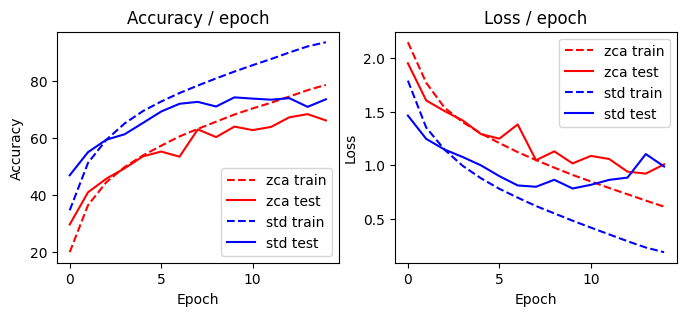

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(np.array(plot_zca.acc_train), label="zca train",color='r',linestyle='--')
plt.plot(np.array(plot_zca.acc_test), label="zca test",color='r')
plt.plot(np.array(plot_std.acc_train), label="std train",color='b',linestyle='--')
plt.plot(np.array(plot_std.acc_test), label="std test",color='b')
plt.title("Accuracy / epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.array(plot_zca.loss_train), label="zca train",color='r',linestyle='--')
plt.plot(np.array(plot_zca.loss_test), label="zca test",color='r')
plt.plot(np.array(plot_std.loss_train), label="std train",color='b',linestyle='--')
plt.plot(np.array(plot_std.loss_test), label="std test",color='b')
plt.title("Loss / epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Normalization')
plt.show()


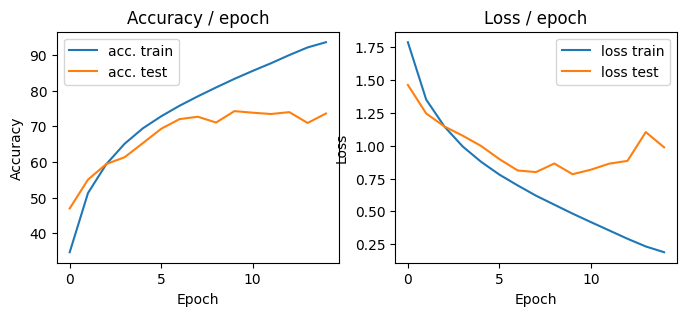

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(np.array(plot_std.acc_train), label="acc. train")
plt.plot(np.array(plot_std.acc_test), label="acc. test")
plt.title("Accuracy / epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.array(plot_std.loss_train), label="loss train")
plt.plot(np.array(plot_std.loss_test), label="loss test")
plt.title("Loss / epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('std normalization')
plt.show()

# 3.2 Cropping and Flipping

In [ ]:
plot_crop,_=main(32, 0.01, epochs=15, cuda=cuda, save_name="batch32_lr0.01_normalization_crop",crop=True,normalize='std')
plot_flip,_=main(32, 0.01, epochs=15, cuda=cuda, save_name="batch32_lr0.01_normalization_crop",flip=0.5,normalize='std')
plot_crop_flip,_=main(32, 0.01, epochs=15, cuda=cuda, save_name="batch32_lr0.01_normalization_crop",crop=True,flip=0.5,normalize='std')

No LR modifying method, lr is constant==0.01
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 42s	Avg loss 1.6056	Avg Prec@1 41.56 %	Avg Prec@5 87.90 %



  7%|▋         | 1/15 [00:45<10:42, 45.90s/it]


===============> Total time 3s	Avg loss 1.2651	Avg Prec@1 54.52 %	Avg Prec@5 94.72 %


===============> Total time 47s	Avg loss 1.1395	Avg Prec@1 59.83 %	Avg Prec@5 95.70 %



 13%|█▎        | 2/15 [01:38<10:47, 49.80s/it]


===============> Total time 5s	Avg loss 1.0314	Avg Prec@1 63.11 %	Avg Prec@5 96.93 %


===============> Total time 54s	Avg loss 0.9260	Avg Prec@1 67.54 %	Avg Prec@5 97.24 %



 20%|██        | 3/15 [02:35<10:39, 53.33s/it]


===============> Total time 3s	Avg loss 0.8849	Avg Prec@1 68.90 %	Avg Prec@5 97.75 %


===============> Total time 40s	Avg loss 0.7746	Avg Prec@1 72.90 %	Avg Prec@5 98.16 %



 27%|██▋       | 4/15 [03:21<09:12, 50.23s/it]


===============> Total time 4s	Avg loss 0.7907	Avg Prec@1 72.59 %	Avg Prec@5 98.10 %


===============> Total time 42s	Avg loss 0.6623	Avg Prec@1 76.83 %	Avg Prec@5 98.71 %



 33%|███▎      | 5/15 [04:06<08:04, 48.48s/it]


===============> Total time 3s	Avg loss 0.7811	Avg Prec@1 73.53 %	Avg Prec@5 97.81 %


===============> Total time 41s	Avg loss 0.5667	Avg Prec@1 80.30 %	Avg Prec@5 99.07 %



 40%|████      | 6/15 [04:52<07:09, 47.69s/it]


===============> Total time 3s	Avg loss 0.6812	Avg Prec@1 77.08 %	Avg Prec@5 98.53 %


===============> Total time 42s	Avg loss 0.4833	Avg Prec@1 83.15 %	Avg Prec@5 99.39 %



 47%|████▋     | 7/15 [05:38<06:15, 46.92s/it]


===============> Total time 3s	Avg loss 0.7025	Avg Prec@1 76.63 %	Avg Prec@5 98.32 %


===============> Total time 41s	Avg loss 0.4069	Avg Prec@1 85.72 %	Avg Prec@5 99.58 %



 53%|█████▎    | 8/15 [06:23<05:24, 46.30s/it]


===============> Total time 3s	Avg loss 0.7350	Avg Prec@1 76.95 %	Avg Prec@5 98.40 %


===============> Total time 41s	Avg loss 0.3420	Avg Prec@1 88.07 %	Avg Prec@5 99.75 %



 60%|██████    | 9/15 [07:09<04:36, 46.13s/it]


===============> Total time 4s	Avg loss 0.7229	Avg Prec@1 77.48 %	Avg Prec@5 98.51 %


===============> Total time 42s	Avg loss 0.2855	Avg Prec@1 90.22 %	Avg Prec@5 99.81 %



 67%|██████▋   | 10/15 [07:54<03:49, 45.91s/it]


===============> Total time 3s	Avg loss 0.7496	Avg Prec@1 77.64 %	Avg Prec@5 98.52 %


===============> Total time 41s	Avg loss 0.2382	Avg Prec@1 91.95 %	Avg Prec@5 99.88 %



 73%|███████▎  | 11/15 [08:39<03:02, 45.54s/it]


===============> Total time 3s	Avg loss 0.7562	Avg Prec@1 78.45 %	Avg Prec@5 98.41 %


===============> Total time 41s	Avg loss 0.2016	Avg Prec@1 93.19 %	Avg Prec@5 99.91 %



 80%|████████  | 12/15 [09:24<02:16, 45.48s/it]


===============> Total time 3s	Avg loss 0.8250	Avg Prec@1 78.04 %	Avg Prec@5 98.50 %


===============> Total time 40s	Avg loss 0.1772	Avg Prec@1 94.04 %	Avg Prec@5 99.93 %



 87%|████████▋ | 13/15 [10:08<01:30, 45.08s/it]


===============> Total time 3s	Avg loss 0.8493	Avg Prec@1 78.29 %	Avg Prec@5 98.53 %


===============> Total time 41s	Avg loss 0.1537	Avg Prec@1 94.75 %	Avg Prec@5 99.95 %



 93%|█████████▎| 14/15 [10:52<00:44, 44.85s/it]


===============> Total time 3s	Avg loss 0.8637	Avg Prec@1 78.82 %	Avg Prec@5 98.54 %


===============> Total time 41s	Avg loss 0.1372	Avg Prec@1 95.43 %	Avg Prec@5 99.96 %



100%|██████████| 15/15 [11:38<00:00, 46.54s/it]


===============> Total time 3s	Avg loss 0.8785	Avg Prec@1 79.31 %	Avg Prec@5 98.50 %

No LR modifying method, lr is constant==0.01


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 39s	Avg loss 1.5796	Avg Prec@1 42.79 %	Avg Prec@5 88.07 %



  7%|▋         | 1/15 [00:42<09:55, 42.53s/it]


===============> Total time 2s	Avg loss 1.2431	Avg Prec@1 56.00 %	Avg Prec@5 94.93 %


===============> Total time 39s	Avg loss 1.1030	Avg Prec@1 60.84 %	Avg Prec@5 96.07 %



 13%|█▎        | 2/15 [01:25<09:20, 43.08s/it]


===============> Total time 3s	Avg loss 0.9867	Avg Prec@1 65.01 %	Avg Prec@5 96.95 %


===============> Total time 42s	Avg loss 0.8771	Avg Prec@1 69.07 %	Avg Prec@5 97.62 %



 20%|██        | 3/15 [02:13<09:03, 45.29s/it]


===============> Total time 4s	Avg loss 0.8447	Avg Prec@1 70.34 %	Avg Prec@5 97.67 %


===============> Total time 43s	Avg loss 0.7331	Avg Prec@1 74.42 %	Avg Prec@5 98.32 %



 27%|██▋       | 4/15 [03:02<08:31, 46.47s/it]


===============> Total time 4s	Avg loss 0.7487	Avg Prec@1 74.09 %	Avg Prec@5 98.18 %


===============> Total time 53s	Avg loss 0.6316	Avg Prec@1 78.03 %	Avg Prec@5 98.78 %



 33%|███▎      | 5/15 [04:00<08:27, 50.76s/it]


===============> Total time 4s	Avg loss 0.7099	Avg Prec@1 75.97 %	Avg Prec@5 98.37 %


===============> Total time 50s	Avg loss 0.5477	Avg Prec@1 81.01 %	Avg Prec@5 99.10 %



 40%|████      | 6/15 [04:55<07:49, 52.21s/it]


===============> Total time 3s	Avg loss 0.6915	Avg Prec@1 76.69 %	Avg Prec@5 98.55 %


===============> Total time 51s	Avg loss 0.4767	Avg Prec@1 83.40 %	Avg Prec@5 99.36 %



 47%|████▋     | 7/15 [05:51<07:07, 53.44s/it]


===============> Total time 4s	Avg loss 0.6949	Avg Prec@1 76.54 %	Avg Prec@5 98.55 %


===============> Total time 63s	Avg loss 0.4089	Avg Prec@1 85.81 %	Avg Prec@5 99.53 %



 53%|█████▎    | 8/15 [06:59<06:46, 58.01s/it]


===============> Total time 4s	Avg loss 0.6696	Avg Prec@1 77.96 %	Avg Prec@5 98.78 %


===============> Total time 56s	Avg loss 0.3460	Avg Prec@1 87.91 %	Avg Prec@5 99.70 %



 60%|██████    | 9/15 [08:02<05:56, 59.48s/it]


===============> Total time 5s	Avg loss 0.6732	Avg Prec@1 78.49 %	Avg Prec@5 98.77 %


===============> Total time 44s	Avg loss 0.2844	Avg Prec@1 89.99 %	Avg Prec@5 99.82 %



 67%|██████▋   | 10/15 [08:49<04:39, 55.89s/it]


===============> Total time 3s	Avg loss 0.7269	Avg Prec@1 78.22 %	Avg Prec@5 98.60 %


===============> Total time 41s	Avg loss 0.2301	Avg Prec@1 92.03 %	Avg Prec@5 99.90 %



 73%|███████▎  | 11/15 [09:35<03:30, 52.73s/it]


===============> Total time 3s	Avg loss 0.7647	Avg Prec@1 77.69 %	Avg Prec@5 98.75 %


===============> Total time 42s	Avg loss 0.1794	Avg Prec@1 93.85 %	Avg Prec@5 99.94 %



 80%|████████  | 12/15 [10:21<02:31, 50.65s/it]


===============> Total time 3s	Avg loss 0.8139	Avg Prec@1 78.12 %	Avg Prec@5 98.58 %


===============> Total time 42s	Avg loss 0.1377	Avg Prec@1 95.27 %	Avg Prec@5 99.97 %



 87%|████████▋ | 13/15 [11:08<01:39, 49.56s/it]


===============> Total time 3s	Avg loss 0.8641	Avg Prec@1 78.91 %	Avg Prec@5 98.75 %


===============> Total time 45s	Avg loss 0.1039	Avg Prec@1 96.48 %	Avg Prec@5 99.99 %



 93%|█████████▎| 14/15 [11:57<00:49, 49.46s/it]


===============> Total time 3s	Avg loss 0.9292	Avg Prec@1 78.35 %	Avg Prec@5 98.51 %


===============> Total time 47s	Avg loss 0.0820	Avg Prec@1 97.26 %	Avg Prec@5 100.00 %



100%|██████████| 15/15 [12:49<00:00, 51.30s/it]


===============> Total time 3s	Avg loss 1.0226	Avg Prec@1 78.69 %	Avg Prec@5 98.55 %

No LR modifying method, lr is constant==0.01


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 71s	Avg loss 1.4773	Avg Prec@1 46.54 %	Avg Prec@5 90.35 %



  7%|▋         | 1/15 [01:15<17:39, 75.64s/it]


===============> Total time 3s	Avg loss 1.3081	Avg Prec@1 53.28 %	Avg Prec@5 94.91 %


===============> Total time 68s	Avg loss 0.9709	Avg Prec@1 65.90 %	Avg Prec@5 97.02 %



 13%|█▎        | 2/15 [02:26<15:50, 73.12s/it]


===============> Total time 3s	Avg loss 0.9414	Avg Prec@1 66.89 %	Avg Prec@5 97.33 %


===============> Total time 69s	Avg loss 0.7586	Avg Prec@1 73.47 %	Avg Prec@5 98.22 %



 20%|██        | 3/15 [03:40<14:37, 73.12s/it]


===============> Total time 3s	Avg loss 0.7374	Avg Prec@1 74.58 %	Avg Prec@5 98.04 %


===============> Total time 61s	Avg loss 0.6303	Avg Prec@1 77.98 %	Avg Prec@5 98.79 %



 27%|██▋       | 4/15 [04:44<12:48, 69.86s/it]


===============> Total time 2s	Avg loss 0.6828	Avg Prec@1 76.38 %	Avg Prec@5 98.51 %


===============> Total time 62s	Avg loss 0.5343	Avg Prec@1 81.21 %	Avg Prec@5 99.19 %



 33%|███▎      | 5/15 [05:50<11:22, 68.20s/it]


===============> Total time 3s	Avg loss 0.6561	Avg Prec@1 77.15 %	Avg Prec@5 98.74 %


===============> Total time 61s	Avg loss 0.4539	Avg Prec@1 84.14 %	Avg Prec@5 99.41 %



 40%|████      | 6/15 [06:55<10:04, 67.11s/it]


===============> Total time 3s	Avg loss 0.6587	Avg Prec@1 77.66 %	Avg Prec@5 98.82 %


===============> Total time 61s	Avg loss 0.3865	Avg Prec@1 86.54 %	Avg Prec@5 99.59 %



 47%|████▋     | 7/15 [08:00<08:51, 66.43s/it]


===============> Total time 3s	Avg loss 0.6008	Avg Prec@1 80.44 %	Avg Prec@5 98.96 %


===============> Total time 62s	Avg loss 0.3247	Avg Prec@1 88.69 %	Avg Prec@5 99.74 %



 53%|█████▎    | 8/15 [09:06<07:43, 66.24s/it]


===============> Total time 2s	Avg loss 0.6520	Avg Prec@1 79.29 %	Avg Prec@5 98.83 %


===============> Total time 63s	Avg loss 0.2698	Avg Prec@1 90.61 %	Avg Prec@5 99.82 %



 60%|██████    | 9/15 [10:12<06:37, 66.33s/it]


===============> Total time 3s	Avg loss 0.6646	Avg Prec@1 80.05 %	Avg Prec@5 98.65 %


===============> Total time 62s	Avg loss 0.2247	Avg Prec@1 92.24 %	Avg Prec@5 99.88 %



 67%|██████▋   | 10/15 [11:18<05:31, 66.21s/it]


===============> Total time 3s	Avg loss 0.6677	Avg Prec@1 80.76 %	Avg Prec@5 98.98 %


===============> Total time 63s	Avg loss 0.1879	Avg Prec@1 93.54 %	Avg Prec@5 99.91 %



 73%|███████▎  | 11/15 [12:25<04:25, 66.45s/it]


===============> Total time 3s	Avg loss 0.7165	Avg Prec@1 80.37 %	Avg Prec@5 98.71 %


===============> Total time 60s	Avg loss 0.1570	Avg Prec@1 94.63 %	Avg Prec@5 99.95 %



 80%|████████  | 12/15 [13:30<03:18, 66.07s/it]


===============> Total time 4s	Avg loss 0.7627	Avg Prec@1 80.64 %	Avg Prec@5 98.68 %


===============> Total time 70s	Avg loss 0.1352	Avg Prec@1 95.40 %	Avg Prec@5 99.97 %



 87%|████████▋ | 13/15 [14:44<02:16, 68.47s/it]


===============> Total time 2s	Avg loss 0.7868	Avg Prec@1 80.63 %	Avg Prec@5 98.75 %


===============> Total time 62s	Avg loss 0.1177	Avg Prec@1 96.05 %	Avg Prec@5 99.98 %



 93%|█████████▎| 14/15 [15:50<01:07, 67.58s/it]


===============> Total time 3s	Avg loss 0.8426	Avg Prec@1 79.95 %	Avg Prec@5 98.86 %


===============> Total time 63s	Avg loss 0.1053	Avg Prec@1 96.52 %	Avg Prec@5 99.98 %



100%|██████████| 15/15 [16:57<00:00, 67.80s/it]


===============> Total time 3s	Avg loss 0.8460	Avg Prec@1 80.56 %	Avg Prec@5 98.52 %



<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

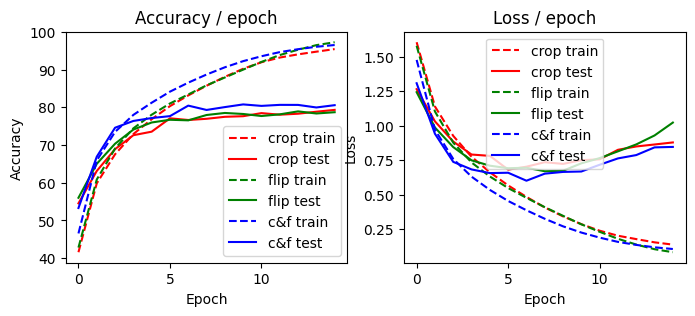

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(np.array(plot_crop[0].acc_train), label="crop train",color='r',linestyle='--')
plt.plot(np.array(plot_crop[0].acc_test), label="crop test",color='r')
plt.plot(np.array(plot_flip[0].acc_train), label="flip train",color='g',linestyle='--')
plt.plot(np.array(plot_flip[0].acc_test), label="flip test",color='g')
plt.plot(np.array(plot_crop_flip[0].acc_train), label="c&f train",color='b',linestyle='--')
plt.plot(np.array(plot_crop_flip[0].acc_test), label="c&f test",color='b')
plt.title("Accuracy / epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.array(plot_crop[0].loss_train), label="crop train",color='r',linestyle='--')
plt.plot(np.array(plot_crop[0].loss_test), label="crop test",color='r')
plt.plot(np.array(plot_flip[0].loss_train), label="flip train",color='g',linestyle='--')
plt.plot(np.array(plot_flip[0].loss_test), label="flip test",color='g')
plt.plot(np.array(plot_crop_flip[0].loss_train), label="c&f train",color='b',linestyle='--')
plt.plot(np.array(plot_crop_flip[0].loss_test), label="c&f test",color='b')
plt.title("Loss / epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Data increase')
plt.show()

# 3.3 LR scheduler

    if scheduler_choice=='StepLR':
      scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    elif scheduler_choice=='MultiStep':
      scheduler = MultiStepLR(optimizer, milestones=[10, 20, 30], gamma=0.5)
    elif scheduler_choice=='ExponentialLR':
      scheduler = ExponentialLR(optimizer, gamma=0.99)
    elif scheduler_choice=='PolynomialLR':
      scheduler = ExponentialLR(optimizer)
    elif scheduler_choice=='LinearLR':
      scheduler = ExponentialLR(optimizer)
    elif scheduler_choice=='CosineAnnealingLR':
      scheduler = ExponentialLR(optimizer)

In [ ]:
loss_train_sh = []
loss_test_sh = []
acc_train_sh = []
acc_test_sh= []
fig1, axes1 = plt.subplots(2, 2, figsize=(8, 8))
axes1[0,0].set_title('Train loss')
axes1[0,1].set_title('Test loss')
axes1[1,0].set_title('Train accuracy')
axes1[1,1].set_title('Test accuracy')
for scheduler_choice in ['StepLR','MultiStep','ExponentialLR','PolynomialLR','LinearLR']:
  plot,_=main(batch=32,lr=0.01, epochs=15, cuda=cuda,save_name="scheduler",crop=True,flip=True,normalize='std',scheduler_choice=scheduler_choice)
  loss_train_sh.append(plot.loss_train)
  loss_test_sh.append(plot.loss_test)
  acc_train_sh.append(plot.acc_train)
  acc_test_sh.append(plot.acc_test)
  axes1[0,0].plot(plot.loss_train,label=scheduler_choice)
  axes1[0,1].plot(plot.loss_test,label=scheduler_choice)
  axes1[1,0].plot(plot.acc_train,label=scheduler_choice)
  axes1[1,1].plot(plot.acc_train,label=scheduler_choice)
axes1[0,0].legend()
axes1[1,0].legend()
axes1[0,1].legend()
axes1[1,1].legend()
fig1.savefig('scheduler')

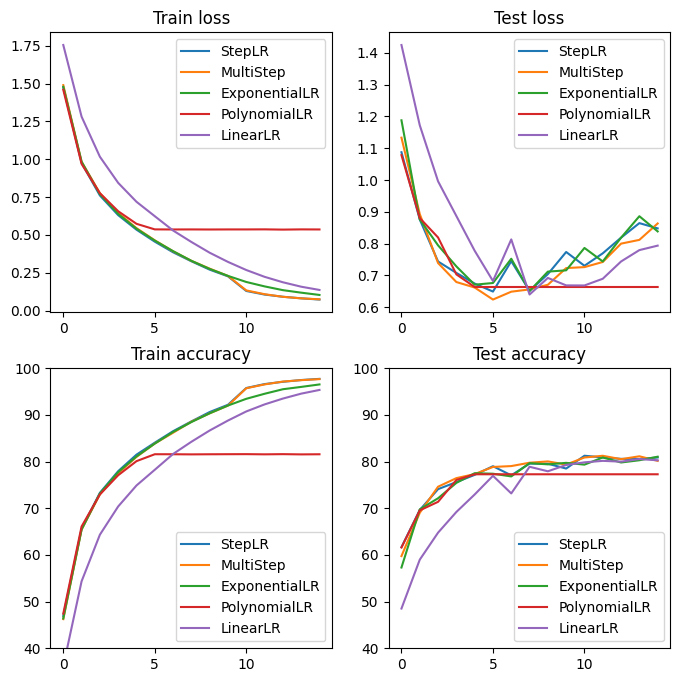

In [ ]:
fig1, axes1 = plt.subplots(2, 2, figsize=(8, 8))
axes1[0,0].set_title('Train loss')
axes1[0,1].set_title('Test loss')
axes1[1,0].set_title('Train accuracy')
axes1[1,1].set_title('Test accuracy')
for i,scheduler_choice in enumerate(['StepLR','MultiStep','ExponentialLR','PolynomialLR','LinearLR']):
  axes1[0,0].plot(loss_train_sh[i],label=scheduler_choice)
  axes1[0,1].plot(loss_test_sh[i],label=scheduler_choice)
  axes1[1,0].plot(acc_train_sh[i],label=scheduler_choice)
  axes1[1,1].plot(acc_test_sh[i],label=scheduler_choice)
axes1[0,0].legend()
axes1[1,0].legend()
axes1[0,1].legend()
axes1[1,1].legend()
axes1[1,0].set_ylim(40,100)
axes1[1,1].set_ylim(40,100)
fig1.savefig('scheduler')

# 3.4 Dropout


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 59s	Avg loss 1.4837	Avg Prec@1 46.28 %	Avg Prec@5 90.33 %



  7%|▋         | 1/15 [01:03<14:45, 63.22s/it]


===============> Total time 3s	Avg loss 1.1047	Avg Prec@1 60.78 %	Avg Prec@5 96.29 %


===============> Total time 59s	Avg loss 0.9799	Avg Prec@1 65.49 %	Avg Prec@5 96.99 %



 13%|█▎        | 2/15 [02:05<13:35, 62.71s/it]


===============> Total time 2s	Avg loss 0.8476	Avg Prec@1 70.97 %	Avg Prec@5 97.78 %


===============> Total time 59s	Avg loss 0.7627	Avg Prec@1 73.30 %	Avg Prec@5 98.12 %



 20%|██        | 3/15 [03:08<12:33, 62.75s/it]


===============> Total time 2s	Avg loss 0.7280	Avg Prec@1 75.38 %	Avg Prec@5 98.25 %


===============> Total time 58s	Avg loss 0.6324	Avg Prec@1 77.98 %	Avg Prec@5 98.77 %



 27%|██▋       | 4/15 [04:09<11:24, 62.23s/it]


===============> Total time 2s	Avg loss 0.6849	Avg Prec@1 76.23 %	Avg Prec@5 98.64 %


===============> Total time 59s	Avg loss 0.5344	Avg Prec@1 81.31 %	Avg Prec@5 99.17 %



 33%|███▎      | 5/15 [05:12<10:24, 62.49s/it]


===============> Total time 2s	Avg loss 0.6378	Avg Prec@1 78.43 %	Avg Prec@5 98.70 %


===============> Total time 58s	Avg loss 0.4584	Avg Prec@1 84.06 %	Avg Prec@5 99.38 %



 40%|████      | 6/15 [06:14<09:18, 62.09s/it]


===============> Total time 2s	Avg loss 0.5981	Avg Prec@1 79.93 %	Avg Prec@5 98.95 %


===============> Total time 57s	Avg loss 0.3886	Avg Prec@1 86.42 %	Avg Prec@5 99.60 %



 47%|████▋     | 7/15 [07:15<08:14, 61.82s/it]


===============> Total time 3s	Avg loss 0.6895	Avg Prec@1 78.07 %	Avg Prec@5 98.76 %


===============> Total time 58s	Avg loss 0.3277	Avg Prec@1 88.63 %	Avg Prec@5 99.71 %



 53%|█████▎    | 8/15 [08:17<07:13, 61.90s/it]


===============> Total time 3s	Avg loss 0.6251	Avg Prec@1 79.87 %	Avg Prec@5 98.87 %


===============> Total time 57s	Avg loss 0.2751	Avg Prec@1 90.44 %	Avg Prec@5 99.84 %



 60%|██████    | 9/15 [09:18<06:10, 61.78s/it]


===============> Total time 3s	Avg loss 0.6267	Avg Prec@1 80.57 %	Avg Prec@5 98.81 %


===============> Total time 57s	Avg loss 0.2298	Avg Prec@1 92.05 %	Avg Prec@5 99.88 %



 67%|██████▋   | 10/15 [10:19<05:07, 61.51s/it]


===============> Total time 3s	Avg loss 0.6698	Avg Prec@1 80.63 %	Avg Prec@5 98.85 %


===============> Total time 58s	Avg loss 0.1365	Avg Prec@1 95.57 %	Avg Prec@5 99.96 %



 73%|███████▎  | 11/15 [11:21<04:06, 61.57s/it]


===============> Total time 3s	Avg loss 0.6868	Avg Prec@1 81.93 %	Avg Prec@5 98.99 %


===============> Total time 58s	Avg loss 0.1086	Avg Prec@1 96.52 %	Avg Prec@5 99.96 %



 80%|████████  | 12/15 [12:22<03:04, 61.45s/it]


===============> Total time 2s	Avg loss 0.7550	Avg Prec@1 81.45 %	Avg Prec@5 98.99 %


===============> Total time 57s	Avg loss 0.0952	Avg Prec@1 97.03 %	Avg Prec@5 99.98 %



 87%|████████▋ | 13/15 [13:23<02:02, 61.26s/it]


===============> Total time 2s	Avg loss 0.7556	Avg Prec@1 81.52 %	Avg Prec@5 98.79 %


===============> Total time 59s	Avg loss 0.0860	Avg Prec@1 97.31 %	Avg Prec@5 99.98 %



 93%|█████████▎| 14/15 [14:26<01:01, 61.63s/it]


===============> Total time 2s	Avg loss 0.7964	Avg Prec@1 81.45 %	Avg Prec@5 98.89 %


===============> Total time 58s	Avg loss 0.0758	Avg Prec@1 97.61 %	Avg Prec@5 99.98 %



100%|██████████| 15/15 [15:27<00:00, 61.80s/it]


===============> Total time 2s	Avg loss 0.8282	Avg Prec@1 81.25 %	Avg Prec@5 99.03 %



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 57s	Avg loss 1.4578	Avg Prec@1 47.21 %	Avg Prec@5 90.68 %



  7%|▋         | 1/15 [01:00<14:03, 60.26s/it]


===============> Total time 2s	Avg loss 1.1380	Avg Prec@1 58.95 %	Avg Prec@5 96.29 %


===============> Total time 58s	Avg loss 0.9599	Avg Prec@1 66.45 %	Avg Prec@5 97.09 %



 13%|█▎        | 2/15 [02:01<13:13, 61.04s/it]


===============> Total time 2s	Avg loss 0.8566	Avg Prec@1 70.22 %	Avg Prec@5 97.53 %


===============> Total time 58s	Avg loss 0.7572	Avg Prec@1 73.62 %	Avg Prec@5 98.20 %



 20%|██        | 3/15 [03:03<12:18, 61.53s/it]


===============> Total time 3s	Avg loss 0.7693	Avg Prec@1 73.00 %	Avg Prec@5 98.07 %


===============> Total time 56s	Avg loss 0.6309	Avg Prec@1 78.03 %	Avg Prec@5 98.78 %



 27%|██▋       | 4/15 [04:04<11:13, 61.22s/it]


===============> Total time 3s	Avg loss 0.6701	Avg Prec@1 76.70 %	Avg Prec@5 98.46 %


===============> Total time 57s	Avg loss 0.5357	Avg Prec@1 81.41 %	Avg Prec@5 99.13 %



 33%|███▎      | 5/15 [05:05<10:10, 61.08s/it]


===============> Total time 3s	Avg loss 0.6699	Avg Prec@1 76.84 %	Avg Prec@5 98.52 %


===============> Total time 58s	Avg loss 0.4576	Avg Prec@1 84.02 %	Avg Prec@5 99.39 %



 40%|████      | 6/15 [06:07<09:11, 61.28s/it]


===============> Total time 2s	Avg loss 0.6558	Avg Prec@1 78.44 %	Avg Prec@5 98.47 %


===============> Total time 58s	Avg loss 0.3900	Avg Prec@1 86.35 %	Avg Prec@5 99.55 %



 47%|████▋     | 7/15 [07:08<08:10, 61.32s/it]


===============> Total time 3s	Avg loss 0.6240	Avg Prec@1 80.08 %	Avg Prec@5 98.74 %


===============> Total time 58s	Avg loss 0.3288	Avg Prec@1 88.53 %	Avg Prec@5 99.71 %



 53%|█████▎    | 8/15 [08:09<07:08, 61.26s/it]


===============> Total time 2s	Avg loss 0.6581	Avg Prec@1 79.08 %	Avg Prec@5 98.72 %


===============> Total time 59s	Avg loss 0.2769	Avg Prec@1 90.39 %	Avg Prec@5 99.81 %



 60%|██████    | 9/15 [09:12<06:09, 61.59s/it]


===============> Total time 2s	Avg loss 0.6757	Avg Prec@1 79.57 %	Avg Prec@5 98.65 %


===============> Total time 58s	Avg loss 0.2316	Avg Prec@1 91.96 %	Avg Prec@5 99.87 %



 67%|██████▋   | 10/15 [10:13<05:07, 61.41s/it]


===============> Total time 2s	Avg loss 0.7314	Avg Prec@1 79.30 %	Avg Prec@5 98.63 %


===============> Total time 56s	Avg loss 0.1374	Avg Prec@1 95.53 %	Avg Prec@5 99.97 %



 73%|███████▎  | 11/15 [11:13<04:04, 61.24s/it]


===============> Total time 3s	Avg loss 0.7001	Avg Prec@1 81.78 %	Avg Prec@5 98.91 %


===============> Total time 58s	Avg loss 0.1148	Avg Prec@1 96.29 %	Avg Prec@5 99.97 %



 80%|████████  | 12/15 [12:15<03:03, 61.31s/it]


===============> Total time 3s	Avg loss 0.7146	Avg Prec@1 82.18 %	Avg Prec@5 98.84 %


===============> Total time 57s	Avg loss 0.0977	Avg Prec@1 96.92 %	Avg Prec@5 99.98 %



 87%|████████▋ | 13/15 [13:15<02:02, 61.07s/it]


===============> Total time 2s	Avg loss 0.7530	Avg Prec@1 81.52 %	Avg Prec@5 98.82 %


===============> Total time 58s	Avg loss 0.0877	Avg Prec@1 97.28 %	Avg Prec@5 99.98 %



 93%|█████████▎| 14/15 [14:17<01:01, 61.10s/it]


===============> Total time 2s	Avg loss 0.7791	Avg Prec@1 81.85 %	Avg Prec@5 98.94 %


===============> Total time 59s	Avg loss 0.0785	Avg Prec@1 97.53 %	Avg Prec@5 99.98 %



100%|██████████| 15/15 [15:19<00:00, 61.30s/it]


===============> Total time 2s	Avg loss 0.8125	Avg Prec@1 82.08 %	Avg Prec@5 98.89 %



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 57s	Avg loss 1.4832	Avg Prec@1 46.41 %	Avg Prec@5 90.46 %



  7%|▋         | 1/15 [01:00<14:03, 60.28s/it]


===============> Total time 2s	Avg loss 1.1448	Avg Prec@1 59.70 %	Avg Prec@5 95.54 %


===============> Total time 57s	Avg loss 0.9986	Avg Prec@1 64.91 %	Avg Prec@5 96.83 %



 13%|█▎        | 2/15 [02:01<13:08, 60.68s/it]


===============> Total time 2s	Avg loss 0.9698	Avg Prec@1 65.75 %	Avg Prec@5 97.24 %


===============> Total time 58s	Avg loss 0.7817	Avg Prec@1 72.59 %	Avg Prec@5 98.11 %



 20%|██        | 3/15 [03:02<12:13, 61.11s/it]


===============> Total time 2s	Avg loss 0.7667	Avg Prec@1 73.94 %	Avg Prec@5 97.91 %


===============> Total time 57s	Avg loss 0.6504	Avg Prec@1 77.25 %	Avg Prec@5 98.74 %



 27%|██▋       | 4/15 [04:03<11:10, 60.97s/it]


===============> Total time 3s	Avg loss 0.7627	Avg Prec@1 73.12 %	Avg Prec@5 98.24 %


===============> Total time 57s	Avg loss 0.5549	Avg Prec@1 80.55 %	Avg Prec@5 99.05 %



 33%|███▎      | 5/15 [05:04<10:10, 61.02s/it]


===============> Total time 3s	Avg loss 0.6488	Avg Prec@1 77.62 %	Avg Prec@5 98.59 %


===============> Total time 57s	Avg loss 0.4756	Avg Prec@1 83.40 %	Avg Prec@5 99.36 %



 40%|████      | 6/15 [06:05<09:09, 61.09s/it]


===============> Total time 3s	Avg loss 0.6532	Avg Prec@1 77.57 %	Avg Prec@5 98.61 %


===============> Total time 57s	Avg loss 0.4047	Avg Prec@1 85.79 %	Avg Prec@5 99.57 %



 47%|████▋     | 7/15 [07:06<08:06, 60.87s/it]


===============> Total time 2s	Avg loss 0.6231	Avg Prec@1 79.96 %	Avg Prec@5 98.67 %


===============> Total time 58s	Avg loss 0.3458	Avg Prec@1 87.87 %	Avg Prec@5 99.72 %



 53%|█████▎    | 8/15 [08:07<07:07, 61.00s/it]


===============> Total time 2s	Avg loss 0.6184	Avg Prec@1 80.64 %	Avg Prec@5 98.82 %


===============> Total time 58s	Avg loss 0.2920	Avg Prec@1 89.79 %	Avg Prec@5 99.81 %



 60%|██████    | 9/15 [09:09<06:07, 61.23s/it]


===============> Total time 2s	Avg loss 0.6703	Avg Prec@1 79.42 %	Avg Prec@5 98.77 %


===============> Total time 58s	Avg loss 0.2471	Avg Prec@1 91.39 %	Avg Prec@5 99.88 %



 67%|██████▋   | 10/15 [10:10<05:05, 61.19s/it]


===============> Total time 2s	Avg loss 0.6714	Avg Prec@1 80.08 %	Avg Prec@5 98.83 %


===============> Total time 57s	Avg loss 0.1509	Avg Prec@1 94.94 %	Avg Prec@5 99.95 %



 73%|███████▎  | 11/15 [11:11<04:04, 61.06s/it]


===============> Total time 2s	Avg loss 0.6993	Avg Prec@1 81.52 %	Avg Prec@5 98.79 %


===============> Total time 58s	Avg loss 0.1262	Avg Prec@1 95.86 %	Avg Prec@5 99.97 %



 80%|████████  | 12/15 [12:13<03:04, 61.34s/it]


===============> Total time 3s	Avg loss 0.7136	Avg Prec@1 81.73 %	Avg Prec@5 98.92 %


===============> Total time 56s	Avg loss 0.1120	Avg Prec@1 96.37 %	Avg Prec@5 99.97 %



 87%|████████▋ | 13/15 [13:13<02:02, 61.12s/it]


===============> Total time 3s	Avg loss 0.7408	Avg Prec@1 81.53 %	Avg Prec@5 98.88 %


===============> Total time 57s	Avg loss 0.0991	Avg Prec@1 96.75 %	Avg Prec@5 99.98 %



 93%|█████████▎| 14/15 [14:14<01:00, 60.89s/it]


===============> Total time 3s	Avg loss 0.8212	Avg Prec@1 80.19 %	Avg Prec@5 98.72 %


===============> Total time 58s	Avg loss 0.0896	Avg Prec@1 97.14 %	Avg Prec@5 99.98 %



100%|██████████| 15/15 [15:15<00:00, 61.06s/it]


===============> Total time 2s	Avg loss 0.8276	Avg Prec@1 81.09 %	Avg Prec@5 98.74 %



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 56s	Avg loss 1.4810	Avg Prec@1 46.43 %	Avg Prec@5 90.43 %



  7%|▋         | 1/15 [01:00<14:11, 60.80s/it]


===============> Total time 3s	Avg loss 1.1390	Avg Prec@1 59.21 %	Avg Prec@5 95.88 %


===============> Total time 57s	Avg loss 0.9822	Avg Prec@1 65.46 %	Avg Prec@5 96.94 %



 13%|█▎        | 2/15 [02:00<13:04, 60.36s/it]


===============> Total time 2s	Avg loss 0.9580	Avg Prec@1 67.45 %	Avg Prec@5 96.76 %


===============> Total time 58s	Avg loss 0.7736	Avg Prec@1 72.92 %	Avg Prec@5 98.16 %



 20%|██        | 3/15 [03:02<12:11, 60.93s/it]


===============> Total time 2s	Avg loss 0.7414	Avg Prec@1 74.23 %	Avg Prec@5 98.29 %


===============> Total time 57s	Avg loss 0.6474	Avg Prec@1 77.41 %	Avg Prec@5 98.75 %



 27%|██▋       | 4/15 [04:03<11:10, 60.93s/it]


===============> Total time 3s	Avg loss 0.6719	Avg Prec@1 76.76 %	Avg Prec@5 98.55 %


===============> Total time 58s	Avg loss 0.5539	Avg Prec@1 80.70 %	Avg Prec@5 99.09 %



 33%|███▎      | 5/15 [05:04<10:10, 61.06s/it]


===============> Total time 2s	Avg loss 0.6358	Avg Prec@1 77.92 %	Avg Prec@5 98.65 %


===============> Total time 58s	Avg loss 0.4783	Avg Prec@1 83.35 %	Avg Prec@5 99.35 %



 40%|████      | 6/15 [06:06<09:12, 61.37s/it]


===============> Total time 2s	Avg loss 0.6180	Avg Prec@1 79.54 %	Avg Prec@5 98.72 %


===============> Total time 58s	Avg loss 0.4149	Avg Prec@1 85.43 %	Avg Prec@5 99.54 %



 47%|████▋     | 7/15 [07:07<08:10, 61.35s/it]


===============> Total time 2s	Avg loss 0.6150	Avg Prec@1 79.29 %	Avg Prec@5 98.79 %


===============> Total time 57s	Avg loss 0.3561	Avg Prec@1 87.62 %	Avg Prec@5 99.68 %



 53%|█████▎    | 8/15 [08:08<07:07, 61.13s/it]


===============> Total time 3s	Avg loss 0.6377	Avg Prec@1 79.57 %	Avg Prec@5 98.86 %


===============> Total time 57s	Avg loss 0.3053	Avg Prec@1 89.32 %	Avg Prec@5 99.78 %



 60%|██████    | 9/15 [09:10<06:08, 61.35s/it]


===============> Total time 3s	Avg loss 0.6370	Avg Prec@1 80.37 %	Avg Prec@5 98.85 %


===============> Total time 57s	Avg loss 0.2628	Avg Prec@1 90.85 %	Avg Prec@5 99.84 %



 67%|██████▋   | 10/15 [10:11<05:06, 61.29s/it]


===============> Total time 3s	Avg loss 0.6405	Avg Prec@1 80.69 %	Avg Prec@5 98.81 %


===============> Total time 57s	Avg loss 0.1706	Avg Prec@1 94.23 %	Avg Prec@5 99.93 %



 73%|███████▎  | 11/15 [11:12<04:04, 61.03s/it]


===============> Total time 2s	Avg loss 0.6451	Avg Prec@1 81.43 %	Avg Prec@5 98.89 %


===============> Total time 59s	Avg loss 0.1456	Avg Prec@1 95.12 %	Avg Prec@5 99.96 %



 80%|████████  | 12/15 [12:14<03:04, 61.47s/it]


===============> Total time 2s	Avg loss 0.6638	Avg Prec@1 82.28 %	Avg Prec@5 98.91 %


===============> Total time 58s	Avg loss 0.1284	Avg Prec@1 95.76 %	Avg Prec@5 99.96 %



 87%|████████▋ | 13/15 [13:15<02:02, 61.39s/it]


===============> Total time 2s	Avg loss 0.7054	Avg Prec@1 81.32 %	Avg Prec@5 98.93 %


===============> Total time 58s	Avg loss 0.1152	Avg Prec@1 96.23 %	Avg Prec@5 99.97 %



 93%|█████████▎| 14/15 [14:16<01:01, 61.27s/it]


===============> Total time 2s	Avg loss 0.7092	Avg Prec@1 81.98 %	Avg Prec@5 98.91 %


===============> Total time 59s	Avg loss 0.1039	Avg Prec@1 96.66 %	Avg Prec@5 99.97 %



100%|██████████| 15/15 [15:18<00:00, 61.26s/it]


===============> Total time 2s	Avg loss 0.7602	Avg Prec@1 81.59 %	Avg Prec@5 98.94 %



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 58s	Avg loss 1.4946	Avg Prec@1 45.86 %	Avg Prec@5 90.22 %



  7%|▋         | 1/15 [01:01<14:15, 61.09s/it]


===============> Total time 2s	Avg loss 1.1139	Avg Prec@1 59.65 %	Avg Prec@5 96.27 %


===============> Total time 58s	Avg loss 1.0021	Avg Prec@1 64.75 %	Avg Prec@5 96.84 %



 13%|█▎        | 2/15 [02:02<13:15, 61.16s/it]


===============> Total time 2s	Avg loss 0.9121	Avg Prec@1 68.35 %	Avg Prec@5 97.55 %


===============> Total time 58s	Avg loss 0.8043	Avg Prec@1 71.81 %	Avg Prec@5 98.01 %



 20%|██        | 3/15 [03:04<12:17, 61.47s/it]


===============> Total time 2s	Avg loss 0.7753	Avg Prec@1 73.36 %	Avg Prec@5 98.09 %


===============> Total time 57s	Avg loss 0.6855	Avg Prec@1 76.16 %	Avg Prec@5 98.55 %



 27%|██▋       | 4/15 [04:05<11:13, 61.24s/it]


===============> Total time 3s	Avg loss 0.7017	Avg Prec@1 76.16 %	Avg Prec@5 98.50 %


===============> Total time 57s	Avg loss 0.6005	Avg Prec@1 78.99 %	Avg Prec@5 98.90 %



 33%|███▎      | 5/15 [05:05<10:11, 61.13s/it]


===============> Total time 3s	Avg loss 0.6419	Avg Prec@1 78.06 %	Avg Prec@5 98.63 %


===============> Total time 58s	Avg loss 0.5303	Avg Prec@1 81.52 %	Avg Prec@5 99.19 %



 40%|████      | 6/15 [06:08<09:15, 61.68s/it]


===============> Total time 3s	Avg loss 0.6455	Avg Prec@1 78.02 %	Avg Prec@5 98.56 %


===============> Total time 63s	Avg loss 0.4720	Avg Prec@1 83.46 %	Avg Prec@5 99.37 %



 47%|████▋     | 7/15 [07:16<08:28, 63.58s/it]


===============> Total time 3s	Avg loss 0.6339	Avg Prec@1 78.78 %	Avg Prec@5 98.70 %


===============> Total time 62s	Avg loss 0.4202	Avg Prec@1 85.19 %	Avg Prec@5 99.54 %



 53%|█████▎    | 8/15 [08:22<07:31, 64.45s/it]


===============> Total time 3s	Avg loss 0.6043	Avg Prec@1 79.84 %	Avg Prec@5 98.86 %


===============> Total time 77s	Avg loss 0.3782	Avg Prec@1 86.74 %	Avg Prec@5 99.61 %



 60%|██████    | 9/15 [09:43<06:58, 69.74s/it]


===============> Total time 4s	Avg loss 0.5727	Avg Prec@1 81.58 %	Avg Prec@5 99.02 %


===============> Total time 75s	Avg loss 0.3373	Avg Prec@1 88.24 %	Avg Prec@5 99.70 %



 67%|██████▋   | 10/15 [11:03<06:03, 72.70s/it]


===============> Total time 3s	Avg loss 0.5987	Avg Prec@1 81.08 %	Avg Prec@5 98.80 %


===============> Total time 76s	Avg loss 0.2477	Avg Prec@1 91.41 %	Avg Prec@5 99.86 %



 73%|███████▎  | 11/15 [12:23<04:59, 74.94s/it]


===============> Total time 3s	Avg loss 0.5767	Avg Prec@1 82.33 %	Avg Prec@5 98.96 %


===============> Total time 78s	Avg loss 0.2208	Avg Prec@1 92.33 %	Avg Prec@5 99.89 %



 80%|████████  | 12/15 [13:46<03:52, 77.55s/it]


===============> Total time 4s	Avg loss 0.6042	Avg Prec@1 81.75 %	Avg Prec@5 98.99 %


===============> Total time 75s	Avg loss 0.2043	Avg Prec@1 92.89 %	Avg Prec@5 99.92 %



 87%|████████▋ | 13/15 [15:06<02:36, 78.23s/it]


===============> Total time 4s	Avg loss 0.5944	Avg Prec@1 82.48 %	Avg Prec@5 99.03 %


===============> Total time 74s	Avg loss 0.1862	Avg Prec@1 93.50 %	Avg Prec@5 99.92 %



 93%|█████████▎| 14/15 [16:25<01:18, 78.32s/it]


===============> Total time 3s	Avg loss 0.6047	Avg Prec@1 82.59 %	Avg Prec@5 99.00 %


===============> Total time 76s	Avg loss 0.1722	Avg Prec@1 94.08 %	Avg Prec@5 99.94 %



100%|██████████| 15/15 [17:45<00:00, 71.05s/it]


===============> Total time 3s	Avg loss 0.6173	Avg Prec@1 82.76 %	Avg Prec@5 99.05 %



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:17<?, ?it/s]


KeyboardInterrupt: ignored

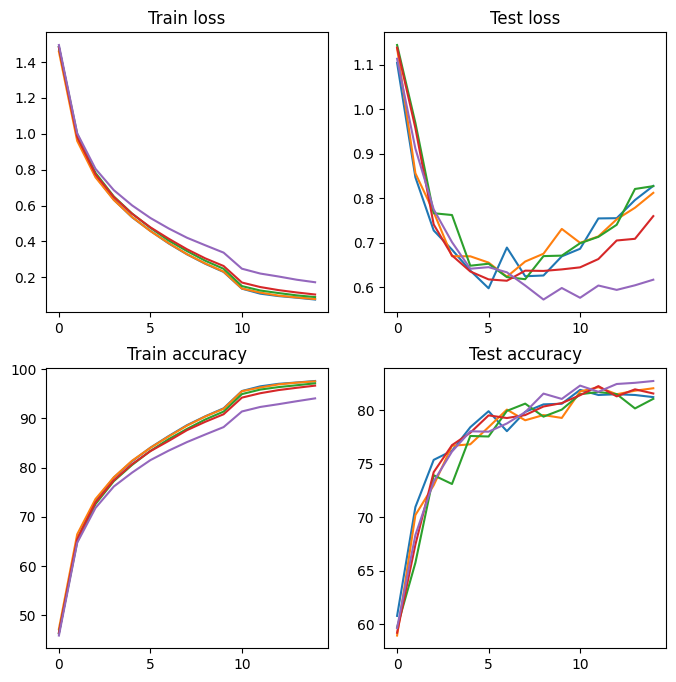

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
loss_train_do = []
loss_test_do = []
acc_train_do = []
acc_test_do = []
fig1, axes1 = plt.subplots(2, 2, figsize=(8, 8))
axes1[0,0].set_title('Train loss')
axes1[0,1].set_title('Test loss')
axes1[1,0].set_title('Train accuracy')
axes1[1,1].set_title('Test accuracy')
for dropout in [0.001,0.01,0.1,0.3,0.5]:
  plot,_=main(32,lr=0.01, epochs=15, cuda=cuda,save_name="scheduler",crop=True,flip=True,normalize='std',scheduler_choice='StepLR',dropout=dropout)
  loss_train_do.append(plot.loss_train)
  loss_test_do.append(plot.loss_test)
  acc_train_do.append(plot.acc_train)
  acc_test_do.append(plot.acc_test)
  axes1[0,0].plot(plot.loss_train,label='dropout={}'.format(dropout))
  axes1[0,1].plot(plot.loss_test,label='dropout={}'.format(dropout))
  axes1[1,0].plot(plot.acc_train,label='dropout={}'.format(dropout))
  axes1[1,1].plot(plot.acc_test,label='dropout={}'.format(dropout))
axes1[0,0].legend()
axes1[1,0].legend()
axes1[0,1].legend()
axes1[1,1].legend()
fig1.savefig('dropout')

# 3.5 Batch normalization

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]


===============> Total time 58s	Avg loss 1.1725	Avg Prec@1 58.07 %	Avg Prec@5 94.75 %



  7%|▋         | 1/15 [01:01<14:23, 61.69s/it]


===============> Total time 2s	Avg loss 1.4505	Avg Prec@1 56.47 %	Avg Prec@5 88.96 %


===============> Total time 56s	Avg loss 0.7997	Avg Prec@1 71.92 %	Avg Prec@5 97.90 %



 13%|█▎        | 2/15 [02:03<13:20, 61.58s/it]


===============> Total time 4s	Avg loss 0.9380	Avg Prec@1 68.98 %	Avg Prec@5 96.20 %


===============> Total time 56s	Avg loss 0.6669	Avg Prec@1 76.63 %	Avg Prec@5 98.62 %



 20%|██        | 3/15 [03:02<12:08, 60.67s/it]


===============> Total time 2s	Avg loss 0.6891	Avg Prec@1 75.45 %	Avg Prec@5 98.40 %


===============> Total time 57s	Avg loss 0.5831	Avg Prec@1 79.61 %	Avg Prec@5 98.94 %



 27%|██▋       | 4/15 [04:03<11:07, 60.69s/it]


===============> Total time 2s	Avg loss 0.7068	Avg Prec@1 76.27 %	Avg Prec@5 98.27 %


===============> Total time 57s	Avg loss 0.5202	Avg Prec@1 81.87 %	Avg Prec@5 99.14 %



 33%|███▎      | 5/15 [05:05<10:10, 61.08s/it]


===============> Total time 3s	Avg loss 0.6430	Avg Prec@1 78.31 %	Avg Prec@5 98.38 %


===============> Total time 56s	Avg loss 0.4696	Avg Prec@1 83.68 %	Avg Prec@5 99.28 %



 40%|████      | 6/15 [06:04<09:05, 60.57s/it]


===============> Total time 2s	Avg loss 0.7255	Avg Prec@1 76.69 %	Avg Prec@5 97.94 %


===============> Total time 57s	Avg loss 0.4260	Avg Prec@1 85.12 %	Avg Prec@5 99.45 %



 47%|████▋     | 7/15 [07:05<08:03, 60.48s/it]


===============> Total time 2s	Avg loss 0.6626	Avg Prec@1 78.38 %	Avg Prec@5 98.47 %


===============> Total time 59s	Avg loss 0.3921	Avg Prec@1 86.32 %	Avg Prec@5 99.50 %



 53%|█████▎    | 8/15 [08:06<07:06, 60.89s/it]


===============> Total time 2s	Avg loss 0.6097	Avg Prec@1 79.69 %	Avg Prec@5 98.67 %


===============> Total time 56s	Avg loss 0.3634	Avg Prec@1 87.40 %	Avg Prec@5 99.60 %



 60%|██████    | 9/15 [09:07<06:04, 60.68s/it]


===============> Total time 3s	Avg loss 0.5860	Avg Prec@1 80.49 %	Avg Prec@5 98.91 %


===============> Total time 57s	Avg loss 0.3346	Avg Prec@1 88.47 %	Avg Prec@5 99.65 %



 67%|██████▋   | 10/15 [10:07<05:02, 60.53s/it]


===============> Total time 2s	Avg loss 0.5622	Avg Prec@1 81.54 %	Avg Prec@5 99.11 %


===============> Total time 59s	Avg loss 0.2687	Avg Prec@1 90.90 %	Avg Prec@5 99.76 %



 73%|███████▎  | 11/15 [11:09<04:03, 60.97s/it]


===============> Total time 2s	Avg loss 0.4888	Avg Prec@1 84.10 %	Avg Prec@5 99.18 %


===============> Total time 57s	Avg loss 0.2505	Avg Prec@1 91.58 %	Avg Prec@5 99.78 %



 80%|████████  | 12/15 [12:10<03:02, 60.98s/it]


===============> Total time 2s	Avg loss 0.5032	Avg Prec@1 83.78 %	Avg Prec@5 99.20 %


===============> Total time 57s	Avg loss 0.2383	Avg Prec@1 91.93 %	Avg Prec@5 99.82 %



 87%|████████▋ | 13/15 [13:11<02:01, 60.91s/it]


===============> Total time 3s	Avg loss 0.5440	Avg Prec@1 82.40 %	Avg Prec@5 99.12 %


===============> Total time 58s	Avg loss 0.2250	Avg Prec@1 92.43 %	Avg Prec@5 99.84 %



 93%|█████████▎| 14/15 [14:12<01:01, 61.00s/it]


===============> Total time 2s	Avg loss 0.5114	Avg Prec@1 83.77 %	Avg Prec@5 99.21 %


===============> Total time 58s	Avg loss 0.2198	Avg Prec@1 92.58 %	Avg Prec@5 99.85 %



100%|██████████| 15/15 [15:13<00:00, 60.89s/it]


===============> Total time 2s	Avg loss 0.5296	Avg Prec@1 83.66 %	Avg Prec@5 99.14 %



<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

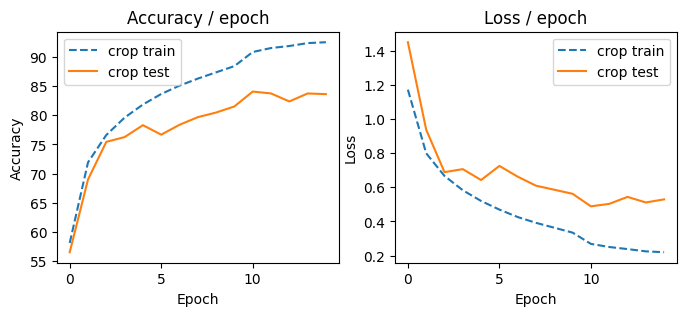

In [ ]:
plot_batch_norm,_=main(32, 0.01, epochs=15, cuda=cuda,
     save_name="batch_norm",
     crop=True, flip=0.5 ,scheduler_choice='StepLR',
     normalize=True,dropout=0.5,batch_normalization=True)


plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(np.array(plot_batch_norm.acc_train), label=" train",linestyle='--')
plt.plot(np.array(plot_batch_norm.acc_test), label="test")
plt.title("Accuracy / epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.array(plot_batch_norm.loss_train), label="train",linestyle='--')
plt.plot(np.array(plot_batch_norm.loss_test), label="test")
plt.title("Loss / epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('batch normalization')
plt.show()